# Brazilian E-Commerce Public Dataset by Olist


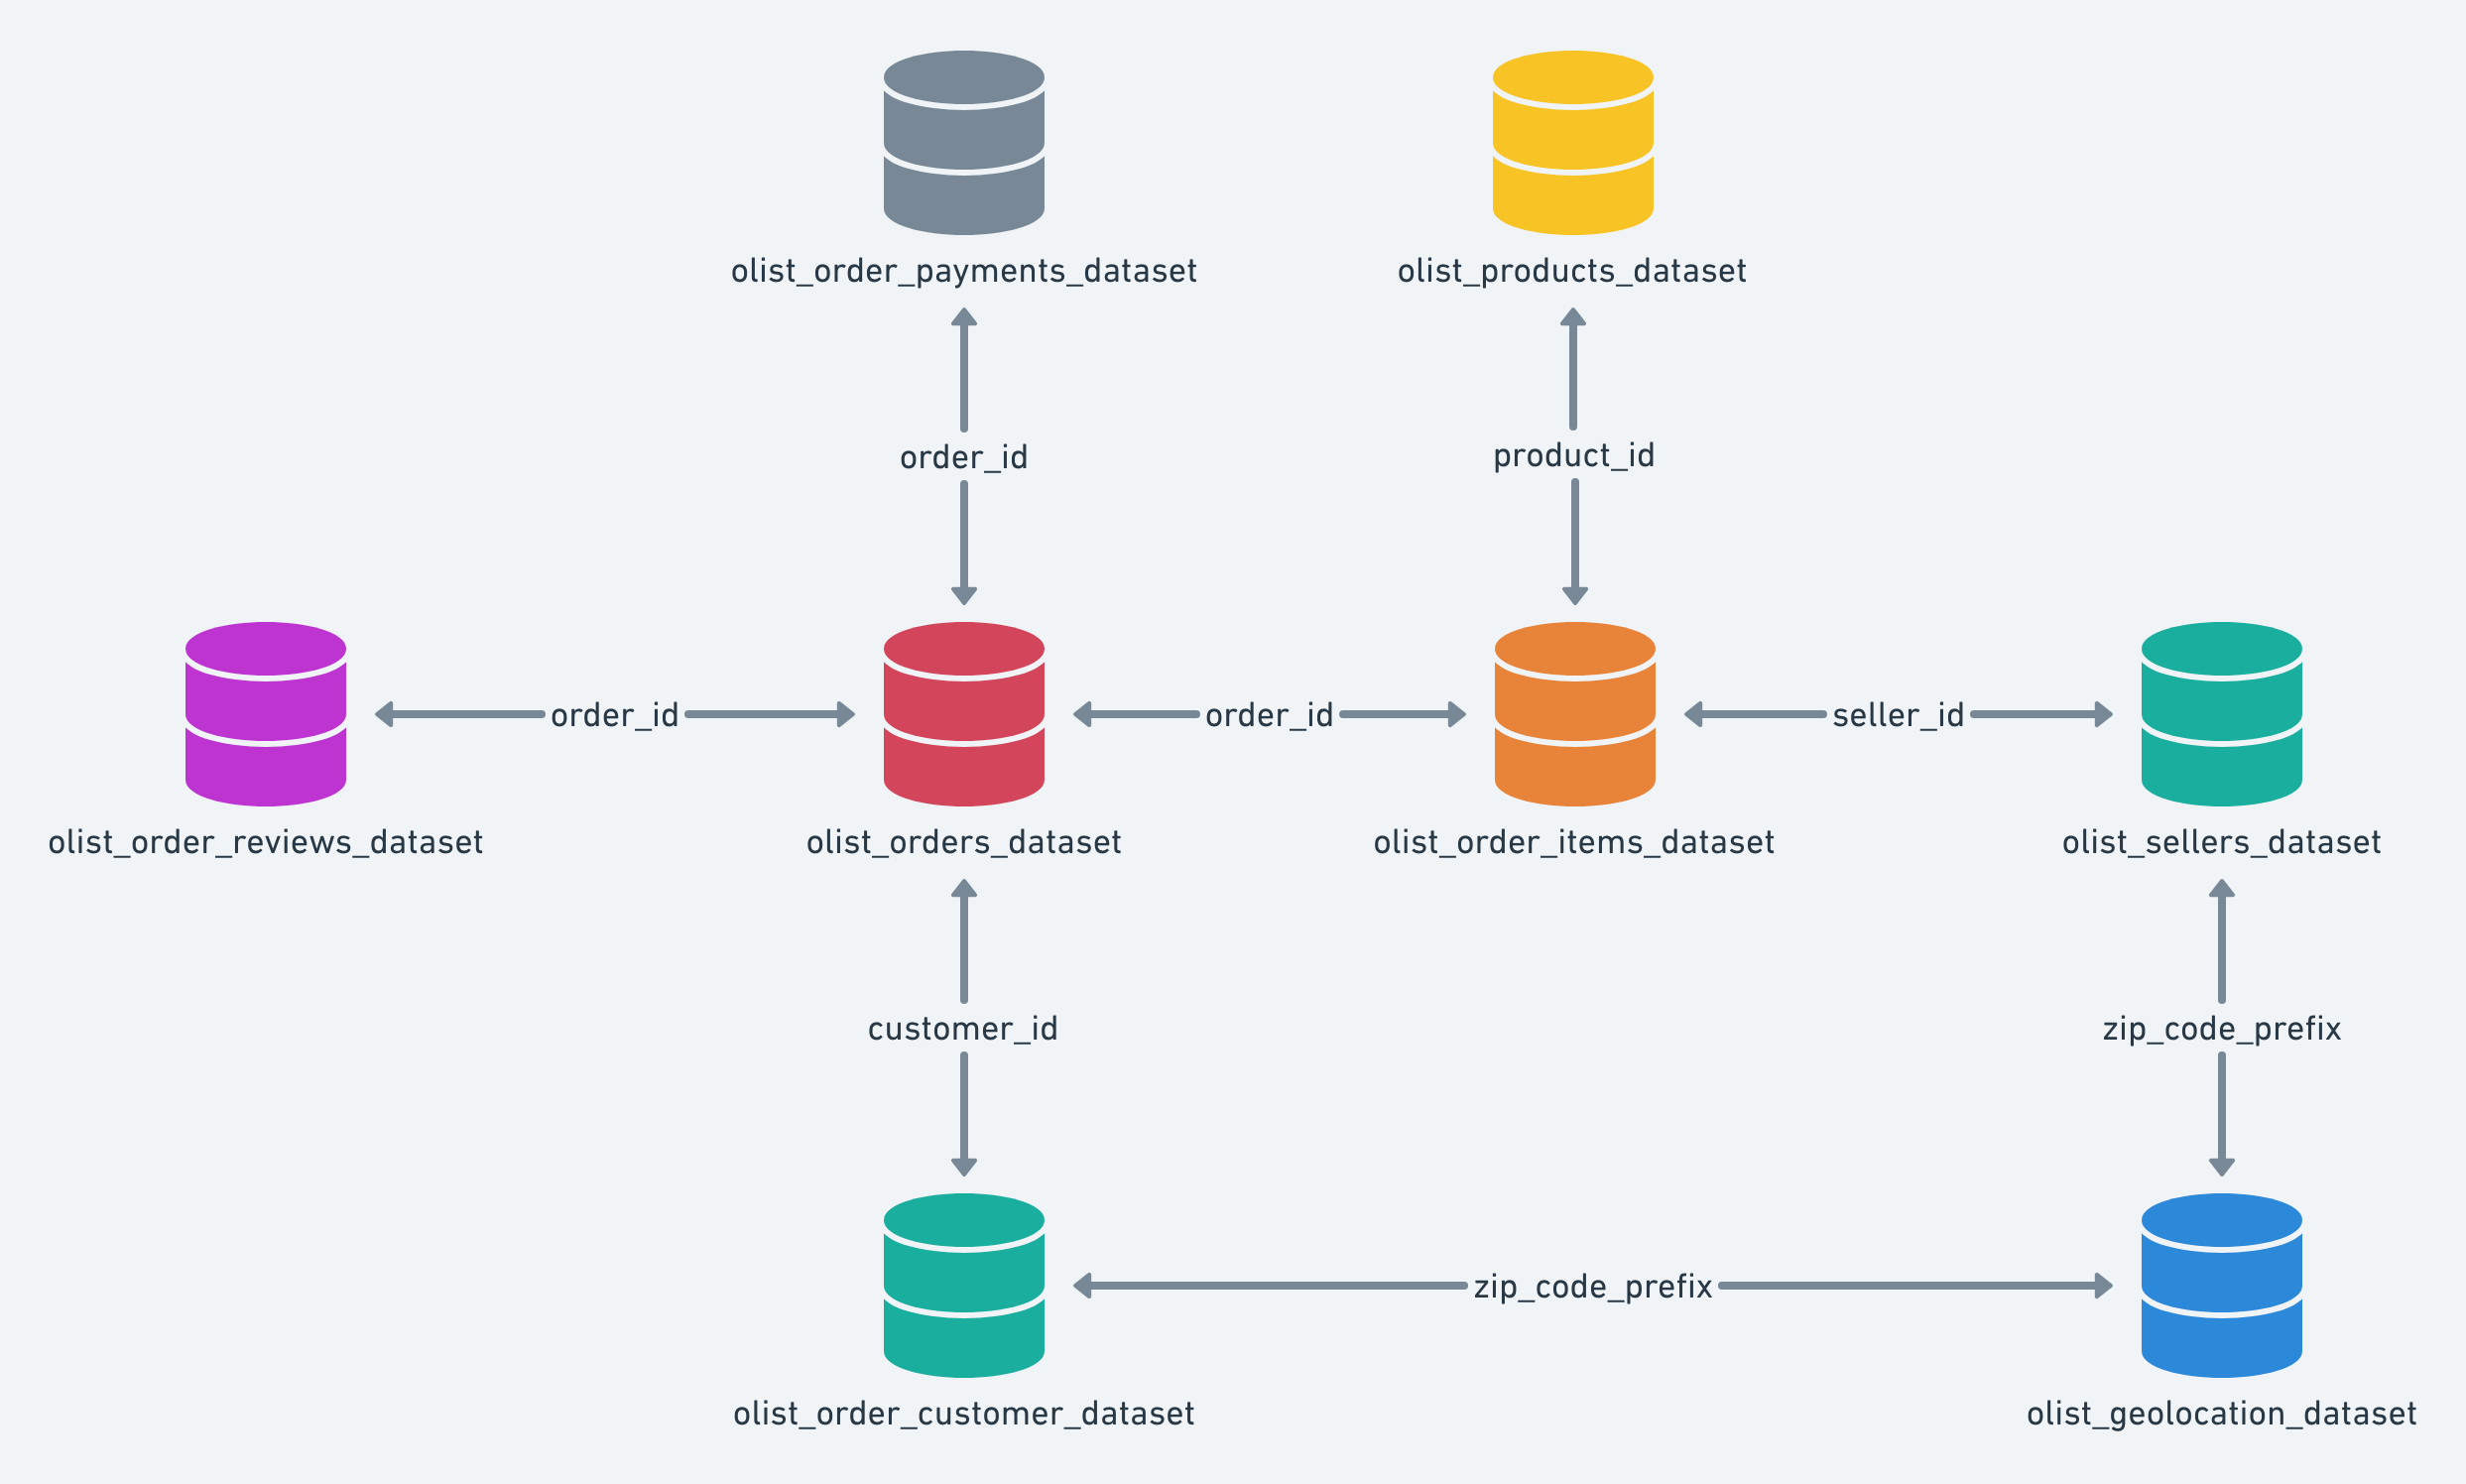

## Download Packages

In [129]:
%pip install kagglehub
%pip install leia-br
# %mkdir /content/data

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [130]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install plotly
%pip install scikit-learn
%pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

##Import Statements

In [131]:
import kagglehub
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import string
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from nltk import ngrams

## Import Data

In [132]:
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)


# Assuming 'path' variable holds the downloaded directory
for filename in os.listdir(path):
  if filename.endswith(".csv"): # Only move csv files
    src = os.path.join(path, filename)
    dst = os.path.join("./data", filename)
    shutil.move(src, dst)
    print(f"Moved {filename} to ./data")

print("CSV files moved successfully.")


100%|██████████| 42.6M/42.6M [00:04<00:00, 11.2MB/s]

Extracting files...


Path to dataset files: C:\Users\srava\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2
Moved olist_customers_dataset.csv to ./data
Moved olist_geolocation_dataset.csv to ./data
Moved olist_orders_dataset.csv to ./data
Moved olist_order_items_dataset.csv to ./data
Moved olist_order_payments_dataset.csv to ./data
Moved olist_order_reviews_dataset.csv to ./data
Moved olist_products_dataset.csv to ./data
Moved olist_sellers_dataset.csv to ./data
Moved product_category_name_translation.csv to ./data
CSV files moved successfully.


#Windows

In [133]:
# !rm -rf /root/.cache/kagglehub/
cache_dir = os.path.join(os.environ["USERPROFILE"], ".cache", "kagglehub")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)

## Create Dataframes

In [134]:

data_dir = 'data'

df_customers = pd.read_csv(data_dir + '/olist_customers_dataset.csv')

df_geolocations = pd.read_csv(data_dir + '/olist_geolocation_dataset.csv')

df_items = pd.read_csv(data_dir + '/olist_order_items_dataset.csv')

df_payments = pd.read_csv(data_dir + '/olist_order_payments_dataset.csv')

df_reviews = pd.read_csv(data_dir + '/olist_order_reviews_dataset.csv')

df_orders = pd.read_csv(data_dir + '/olist_orders_dataset.csv')

df_products = pd.read_csv(data_dir + '/olist_products_dataset.csv')

df_sellers = pd.read_csv(data_dir + '/olist_sellers_dataset.csv')

df_product_category_name_translation = pd.read_csv(data_dir + '/product_category_name_translation.csv')


In [135]:
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


# Data Cleaning

## Cleaning Customers

In [136]:
# Check for missing values
print(df_customers.isnull().sum())

# Check for duplicates
print(df_customers.duplicated().sum())

df_customers['customer_city'] = df_customers['customer_city'].astype(str)
df_customers['customer_state'] = df_customers['customer_state'].astype(str)

df_customers.info()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


###Cleaning Wrong Addresses

In [137]:
df_geolocations['geolocation_city'] = df_geolocations['geolocation_city'].astype(str)
df_geolocations['geolocation_state'] = df_geolocations['geolocation_state'].astype(str)

In [138]:
unique_zipcodes = df_customers['customer_zip_code_prefix'].unique().tolist()

In [139]:
# Group by zip code and get the first city and state for each zip code
df_zipcode_location = df_geolocations.groupby('geolocation_zip_code_prefix').agg(
    city=('geolocation_city', 'first'),
    state=('geolocation_state', 'first')
).reset_index()

df_zipcode_location = df_zipcode_location.rename(columns={
    'geolocation_zip_code_prefix': 'zipcode'
})

In [140]:
zipcode_location_dict = {}

for zipcode in unique_zipcodes:
    location_data = df_zipcode_location.loc[df_zipcode_location['zipcode'] == zipcode, ['city', 'state']]

    if not location_data.empty:
        city = location_data['city'].iloc[0]
        state = location_data['state'].iloc[0]
        zipcode_location_dict[zipcode] = (city, state)

In [141]:
indices_to_drop = []
for index, row in df_customers.iterrows():
  zipcode = row['customer_zip_code_prefix']
  city = row['customer_city']
  state = row['customer_state']

  if zipcode in zipcode_location_dict:
    if city != zipcode_location_dict[zipcode][0] or state != zipcode_location_dict[zipcode][1]:
      indices_to_drop.append(index)
  else:
    indices_to_drop.append(index)

print(len(indices_to_drop))

df_customers = df_customers.drop(indices_to_drop)

7523


## Cleaning Geolocations

In [142]:
# Check for missing values
print(df_geolocations.isnull().sum())

# Check for duplicates
print(df_geolocations.duplicated().sum())

df_geolocations = df_geolocations.drop_duplicates()

print("no of duplicates", df_geolocations.duplicated().sum())
df_geolocations.info()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
261831
no of duplicates 0
<class 'pandas.core.frame.DataFrame'>
Index: 738332 entries, 0 to 1000161
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  738332 non-null  int64  
 1   geolocation_lat              738332 non-null  float64
 2   geolocation_lng              738332 non-null  float64
 3   geolocation_city             738332 non-null  object 
 4   geolocation_state            738332 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 33.8+ MB


## Cleaning Items

In [143]:
# Check for missing values
print(df_items.isnull().sum())

# Check for duplicates
print(df_items.duplicated().sum())

# print(df_geolocations.head())
df_items.info()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


## Cleaning Payments

In [144]:
# Check for missing values
print(df_payments.isnull().sum())

# Check for duplicates
print(df_payments.duplicated().sum())

# print(df_geolocations.head())
df_payments.info()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


## Cleaning Reviews

In [145]:
# Check for missing values
print(df_reviews.isnull().sum())

# Check for duplicates
print(df_reviews.duplicated().sum())

# print(df_geolocations.head())
df_reviews.info()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


###Added new attribute 'review_type': [good, neutral, bad]

In [146]:
df_reviews['review_type'] = pd.cut(df_reviews['review_score'], bins=[0, 3, 3.1, 5], labels=['bad', 'neutral', 'good'], right=False)
df_reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   review_id                99224 non-null  object  
 1   order_id                 99224 non-null  object  
 2   review_score             99224 non-null  int64   
 3   review_comment_title     11568 non-null  object  
 4   review_comment_message   40977 non-null  object  
 5   review_creation_date     99224 non-null  object  
 6   review_answer_timestamp  99224 non-null  object  
 7   review_type              41896 non-null  category
dtypes: category(1), int64(1), object(6)
memory usage: 5.4+ MB


## Cleaning Orders

In [147]:
# Check for missing values
print(df_orders.isnull().sum())

# Check for duplicates
print(df_orders.duplicated().sum())

df_orders.info()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 

In [148]:
# Drop rows where order_approved_at is null but order_status is in a specific set
status_list = ['approved', 'processing', 'shipped', 'invoiced', 'delivered']
df_orders = df_orders.drop(df_orders[(df_orders['order_approved_at'].isnull()) & (df_orders['order_status'].isin(status_list))].index)

# Drop rows where order_delivered_carrier_date is null but order_status is in another specific set
status_list2 = ['invoiced', 'delivered']
df_orders = df_orders.drop(df_orders[(df_orders['order_delivered_carrier_date'].isnull()) & (df_orders['order_status'].isin(status_list2))].index)

# Drop rows where order_delivered_customer_date is null but order_status is in another specific set
status_list3 = 'delivered'
df_orders = df_orders.drop(df_orders[(df_orders['order_delivered_customer_date'].isnull()) & (df_orders['order_status'] == status_list3)].index)

print(df_orders.isnull().sum())

# Check for duplicates
print(df_orders.duplicated().sum())


order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 146
order_delivered_carrier_date     1467
order_delivered_customer_date    2643
order_estimated_delivery_date       0
dtype: int64
0


## Cleaning Products

In [149]:
print(df_products.isnull().sum())
# Check for duplicates
print(df_products.duplicated().sum())

df_products.info()

df_products = df_products.drop(df_products[df_products['product_category_name'].isnull() |
                                           ((df_products['product_name_lenght'].isnull() | df_products['product_photos_qty'].isnull()) &
                                           df_products['product_description_lenght'].isnull()) |
                                           df_products['product_weight_g'].isnull() |
                                           (df_products['product_length_cm'].isnull() &
                                           df_products['product_height_cm'].isnull() &
                                           df_products['product_width_cm'].isnull())
                                           ].index)

print(df_products.isnull().sum())

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 

### Replaced all the Espanol values of 'product_name_category' in the df_products to english using the df_product_category_name_translation

In [150]:
translation_dict = dict(zip(df_product_category_name_translation['product_category_name'],
                            df_product_category_name_translation['product_category_name_english']))


df_products['product_category_name'] = df_products['product_category_name'].replace(translation_dict)

## Cleaning Sellers

In [151]:
# Check for missing values
print(df_sellers.isnull().sum())

# Check for duplicates
print(df_sellers.duplicated().sum())

df_sellers.info()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


## Cleaning Product category name translations

In [152]:
# Check for missing values
print(df_product_category_name_translation.isnull().sum())

# Check for duplicates
print(df_product_category_name_translation.duplicated().sum())

df_product_category_name_translation.info()

product_category_name            0
product_category_name_english    0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


# Outlier Analysis

## Order Items Table

Outlier analysis for price:
Number of outliers (IQR): 8427
Number of outliers (Z-score): 1966


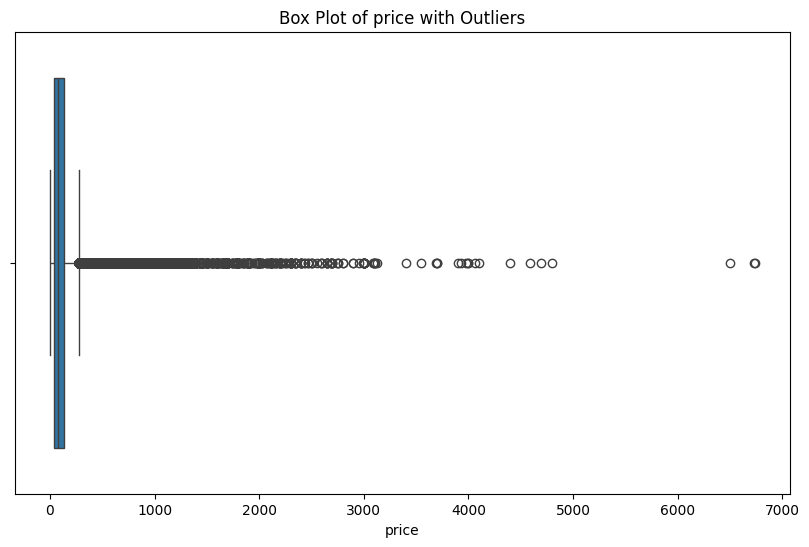

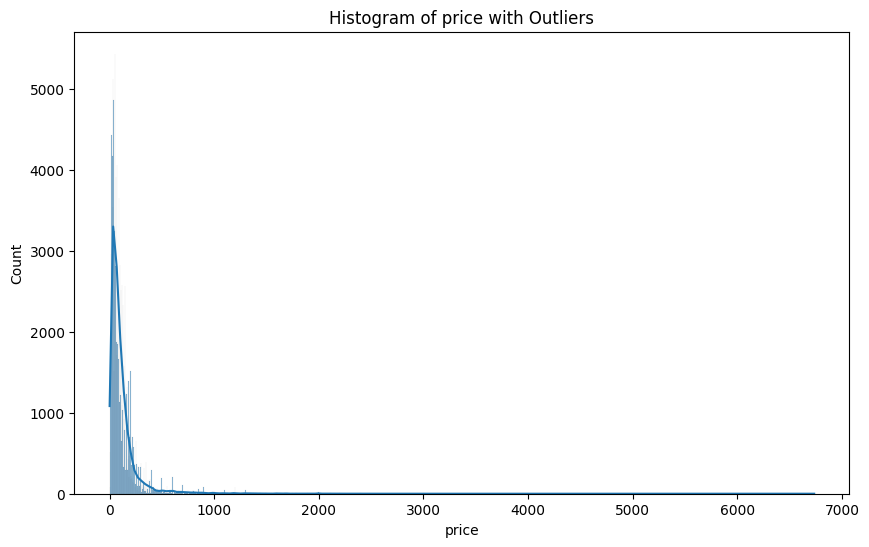

Outlier analysis for freight_value:
Number of outliers (IQR): 12134
Number of outliers (Z-score): 2041


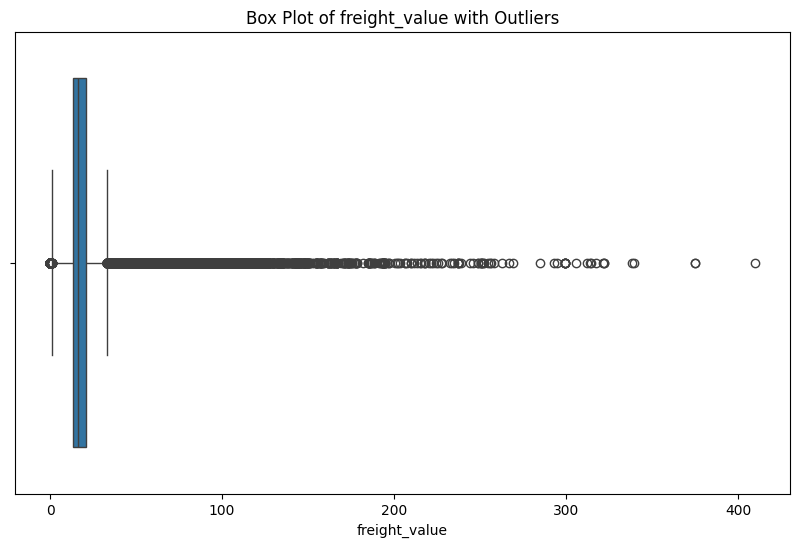

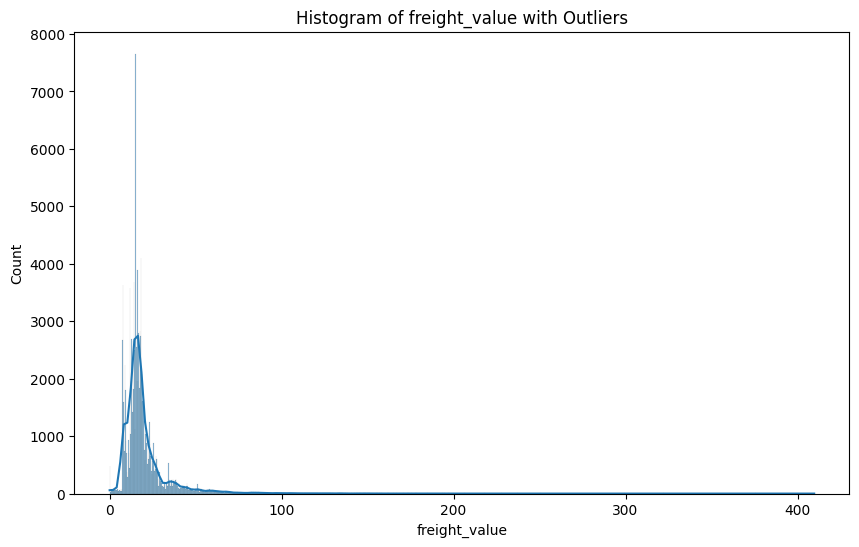

In [153]:
# Neccessary Functions
def find_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

def find_outliers_zscore(data):
    threshold = 3
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    outliers = data[z_scores > threshold]
    return outliers

for col in ['price', 'freight_value']:
    print(f"Outlier analysis for {col}:")

    # IQR method
    iqr_outliers = find_outliers_iqr(df_items[col])
    print(f"Number of outliers (IQR): {len(iqr_outliers)}")
    # print(f"IQR Outliers: {iqr_outliers}")

    # Z-score method
    zscore_outliers = find_outliers_zscore(df_items[col])
    print(f"Number of outliers (Z-score): {len(zscore_outliers)}")

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_items[col])
    plt.title(f"Box Plot of {col} with Outliers")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(df_items[col], kde=True)
    plt.title(f"Histogram of {col} with Outliers")
    plt.show()


## Payments Table

Outlier analysis for payment_value:
Number of outliers (IQR): 7981
Number of outliers (Z-score): 1803


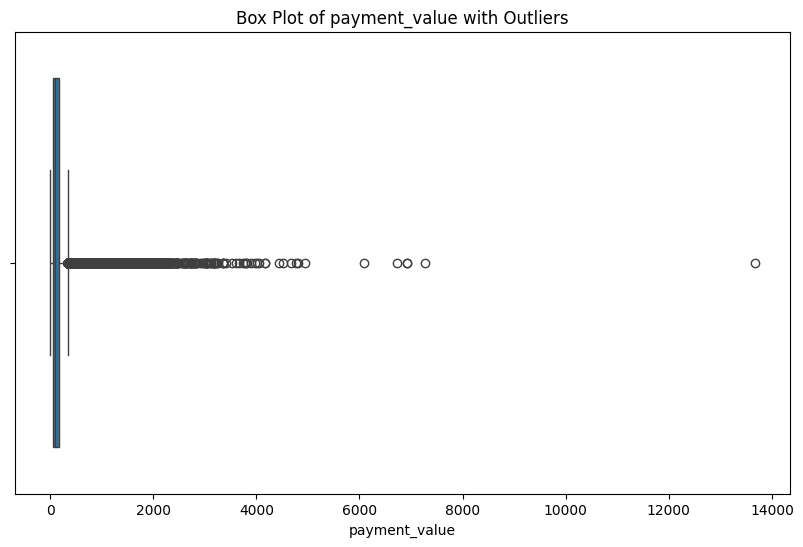

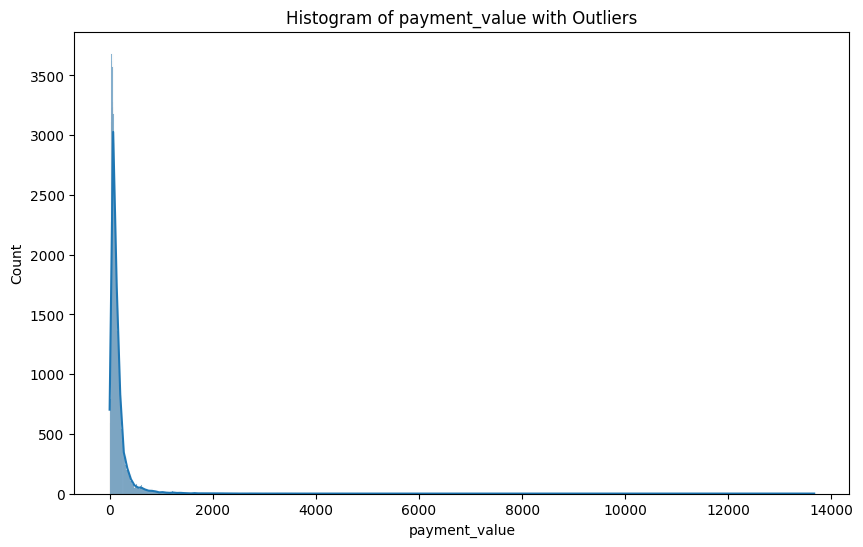

In [154]:
col = 'payment_value'
print(f"Outlier analysis for {col}:")

# IQR method
iqr_outliers = find_outliers_iqr(df_payments[col])
print(f"Number of outliers (IQR): {len(iqr_outliers)}")

# Z-score method
zscore_outliers = find_outliers_zscore(df_payments[col])
print(f"Number of outliers (Z-score): {len(zscore_outliers)}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_payments[col])
plt.title(f"Box Plot of {col} with Outliers")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_payments[col], kde=True)
plt.title(f"Histogram of {col} with Outliers")
plt.show()


## Products Table

Outlier analysis for product_weight_g:
Number of outliers (IQR): 4478
Number of outliers (Z-score): 937


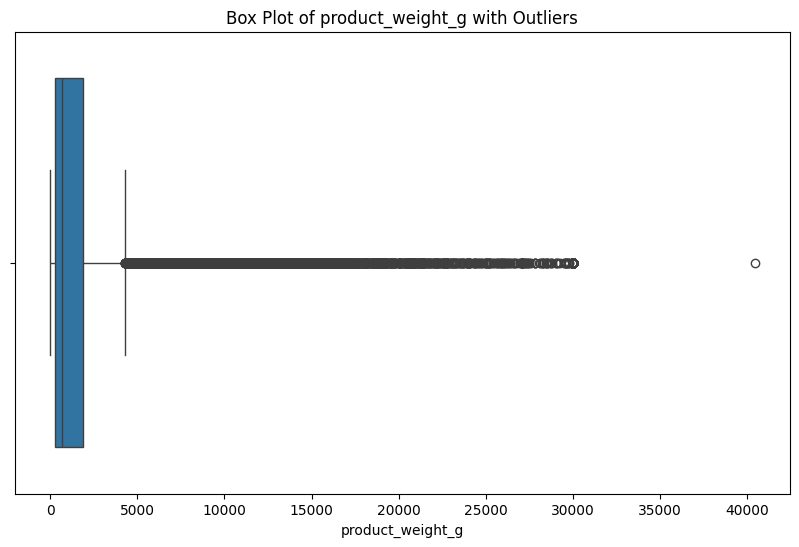

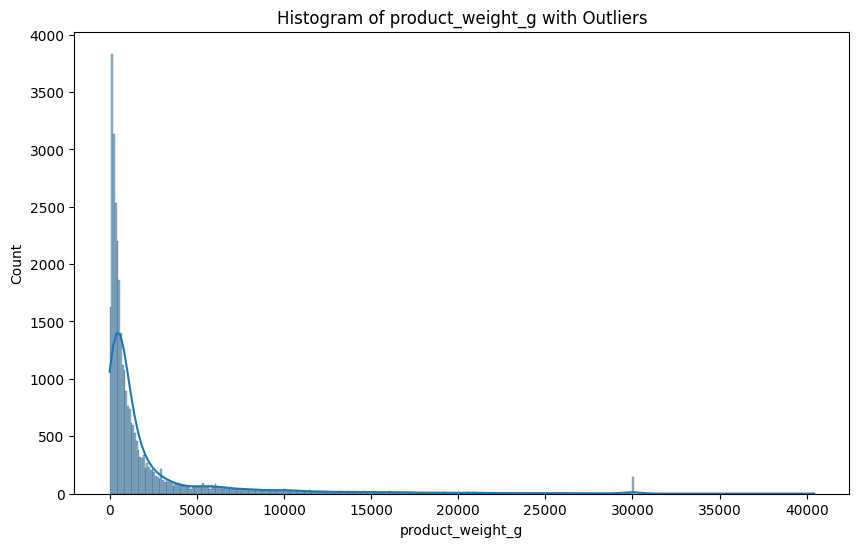

Outlier analysis for product_length_cm:
Number of outliers (IQR): 1365
Number of outliers (Z-score): 613


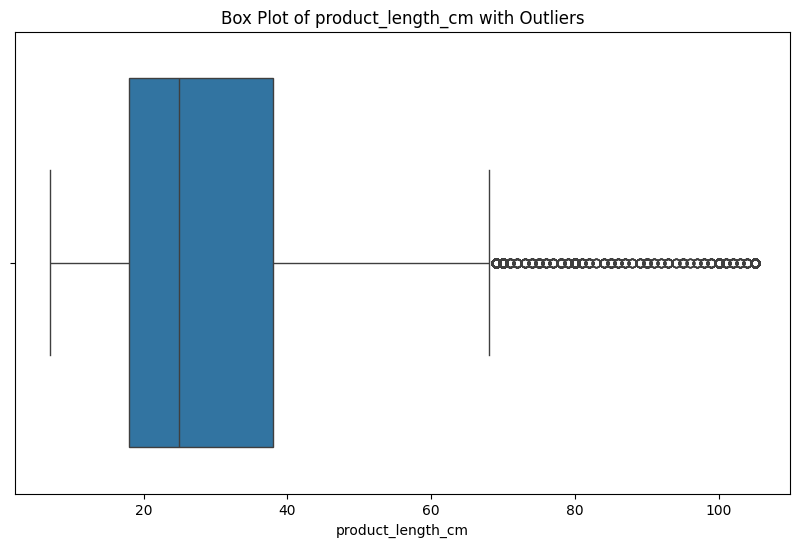

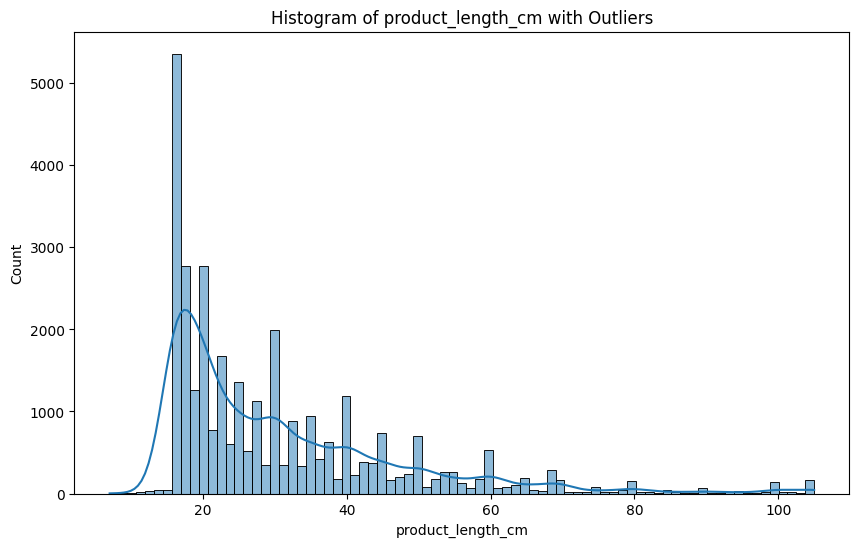

Outlier analysis for product_height_cm:
Number of outliers (IQR): 1870
Number of outliers (Z-score): 719


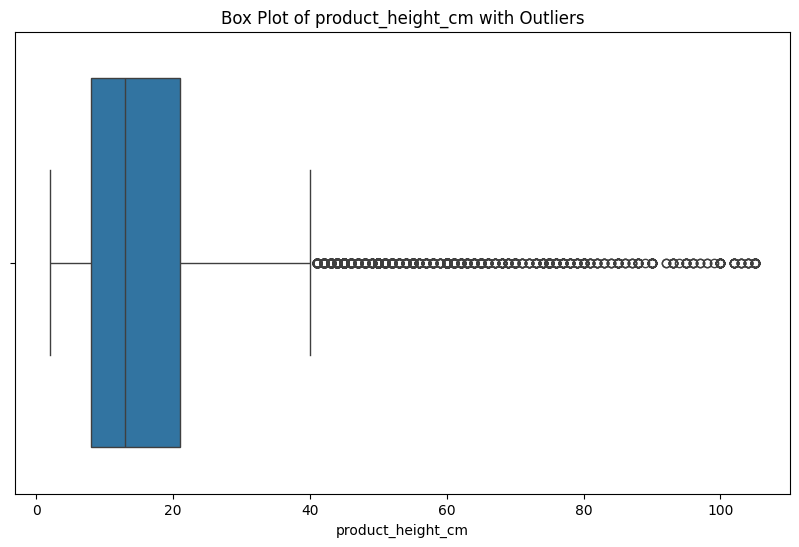

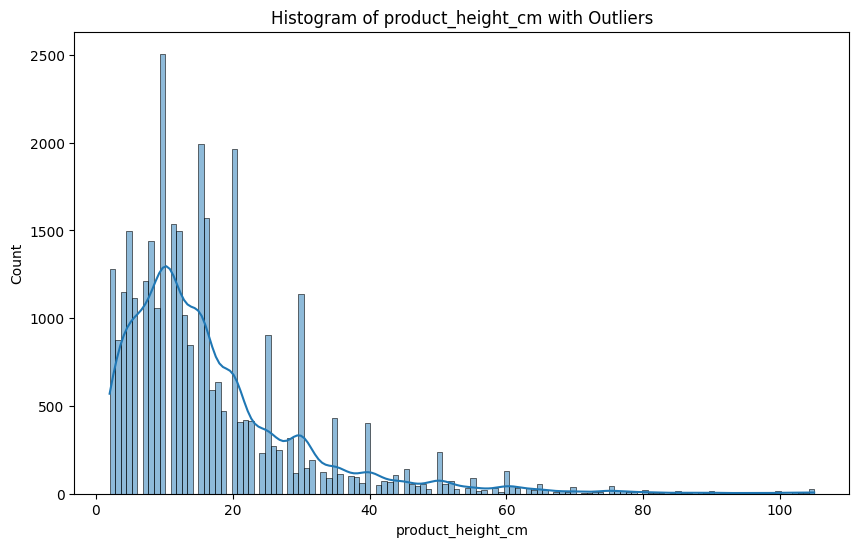

Outlier analysis for product_width_cm:
Number of outliers (IQR): 897
Number of outliers (Z-score): 567


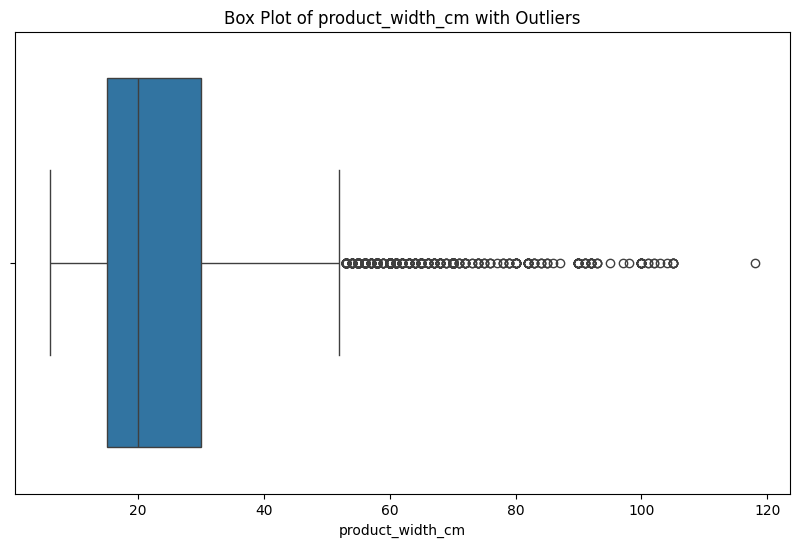

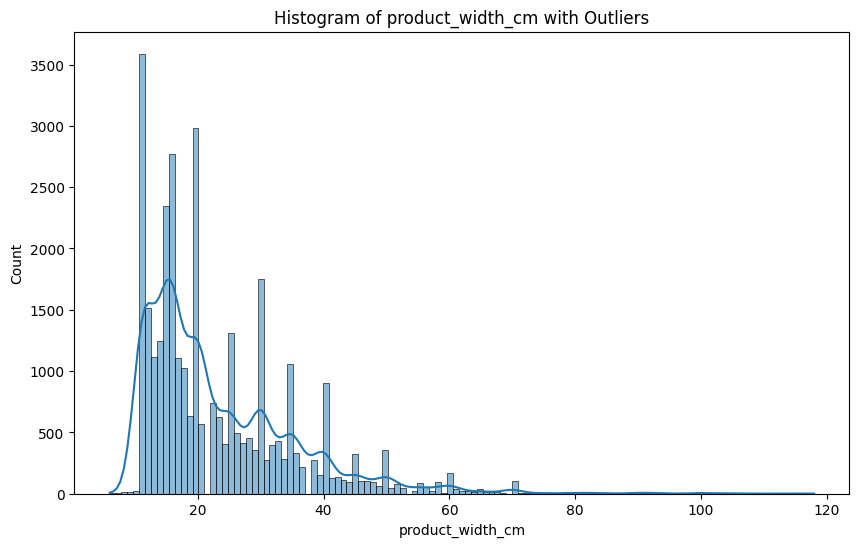

In [155]:
columns_to_analyze = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

for col in columns_to_analyze:
    # Handling potential missing values
    if col in df_products.columns and not df_products[col].isnull().all():
        print(f"Outlier analysis for {col}:")

        # IQR method
        iqr_outliers = find_outliers_iqr(df_products[col].dropna()) # Drop NaN for IQR
        print(f"Number of outliers (IQR): {len(iqr_outliers)}")

        # Z-score method
        zscore_outliers = find_outliers_zscore(df_products[col].dropna()) # Drop NaN for Z-score
        print(f"Number of outliers (Z-score): {len(zscore_outliers)}")

        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df_products[col].dropna()) # Drop NaN for boxplot
        plt.title(f"Box Plot of {col} with Outliers")
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.histplot(df_products[col].dropna(), kde=True) # Drop NaN for histplot
        plt.title(f"Histogram of {col} with Outliers")
        plt.show()
    else:
        print(f"Column '{col}' not found or contains only missing values in the dataframe.")


# Descriptive Analysis

## Customers Table

                             customer_id                customer_unique_id  \
count                              91918                             91918   
unique                             91918                             88848   
top     274fa6071e5e17fe303b9748641082c8  8d50f5eadf50201ccdcedfb9e2ac8455   
freq                                   1                                17   
mean                                 NaN                               NaN   
std                                  NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   

        customer_zip_code_prefix customer_city customer_state  

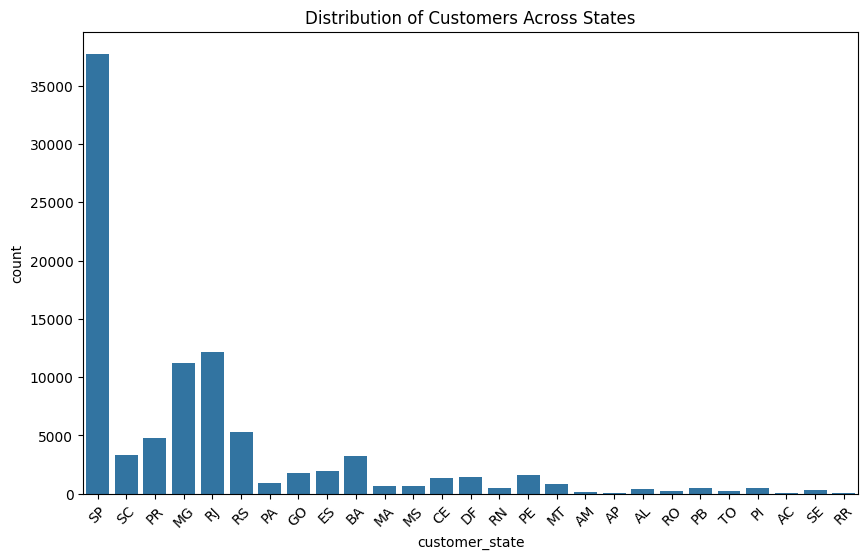

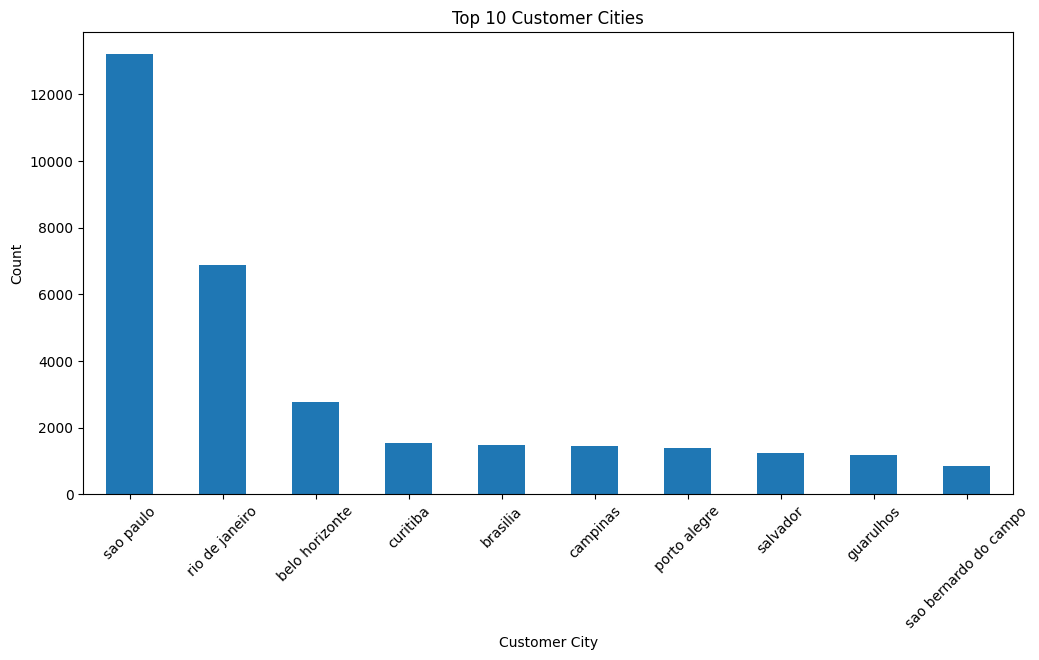

In [156]:
print(df_customers.describe(include='all'))

# Explore specific columns
print(df_customers['customer_city'].value_counts())
print(df_customers['customer_state'].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='customer_state', data=df_customers)
plt.title('Distribution of Customers Across States')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
df_customers['customer_city'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Customer Cities')
plt.xlabel('Customer City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


## Geolocations Table

        geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
count                 738332.000000    738332.000000    738332.000000   
unique                          NaN              NaN              NaN   
top                             NaN              NaN              NaN   
freq                            NaN              NaN              NaN   
mean                   38316.086800       -20.998353       -46.461098   
std                    30632.496675         5.892315         4.393705   
min                     1001.000000       -36.605374      -101.466766   
25%                    12600.000000       -23.603061       -48.867822   
50%                    29144.000000       -22.873588       -46.647278   
75%                    65950.000000       -19.923336       -43.836974   
max                    99990.000000        45.065933       121.105394   

       geolocation_city geolocation_state  
count            738332            738332  
unique             8011            

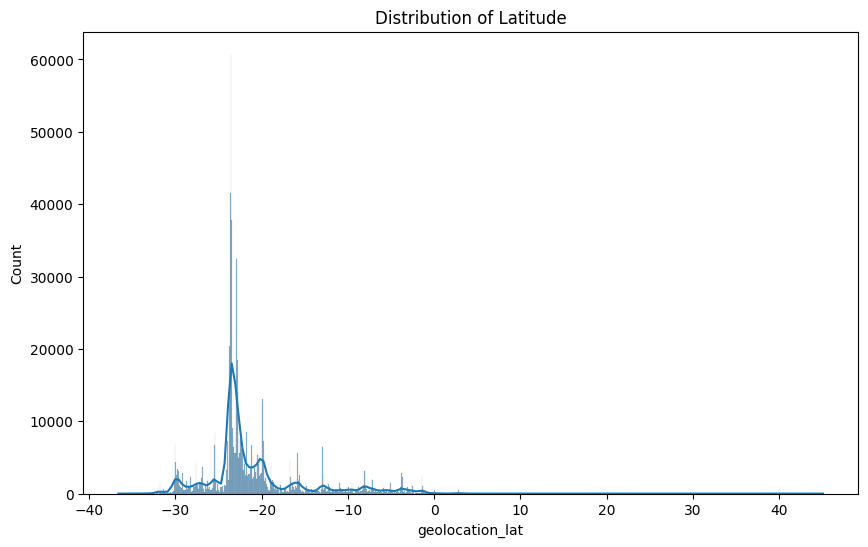

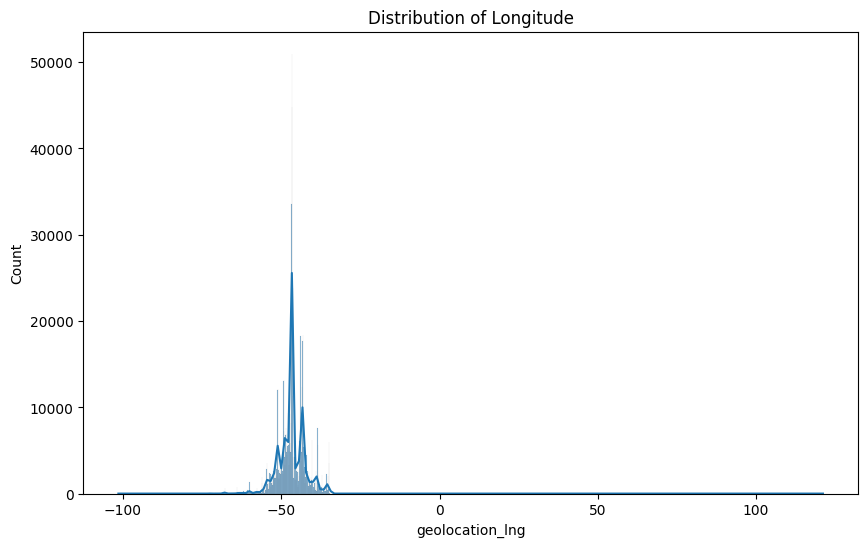

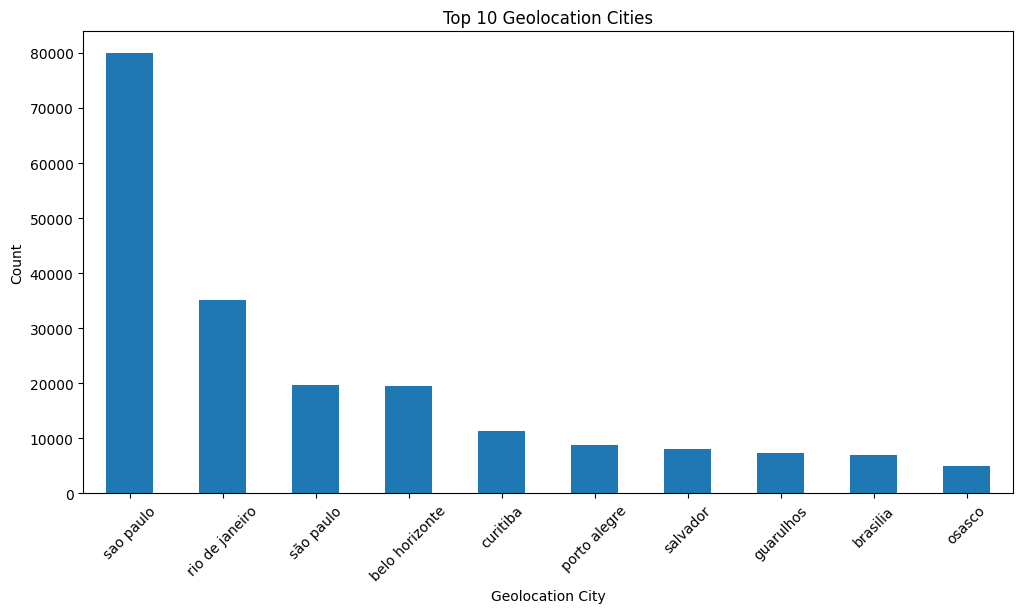

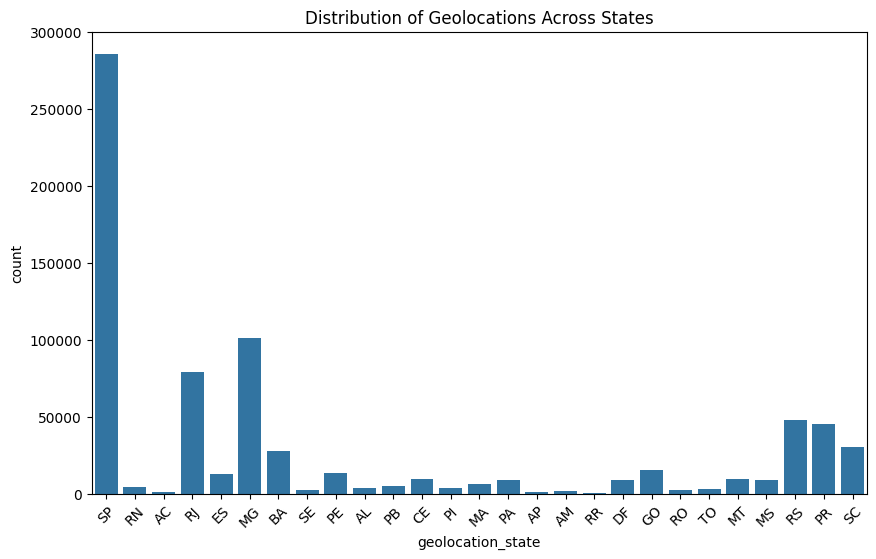

In [157]:
print(df_geolocations.describe(include='all'))

print(df_geolocations['geolocation_lat'].describe())
print(df_geolocations['geolocation_lng'].describe())
print(df_geolocations['geolocation_city'].value_counts())
print(df_geolocations['geolocation_state'].value_counts())

plt.figure(figsize=(10, 6))
sns.histplot(df_geolocations['geolocation_lat'], kde=True)
plt.title('Distribution of Latitude')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_geolocations['geolocation_lng'], kde=True)
plt.title('Distribution of Longitude')
plt.show()

plt.figure(figsize=(12, 6))
df_geolocations['geolocation_city'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Geolocation Cities')
plt.xlabel('Geolocation City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='geolocation_state', data=df_geolocations)
plt.title('Distribution of Geolocations Across States')
plt.xticks(rotation=45)
plt.show()


## Order Items Table

                                order_id  order_item_id  \
count                             112650  112650.000000   
unique                             98666            NaN   
top     8272b63d03f5f79c56e9e4120aec44ef            NaN   
freq                                  21            NaN   
mean                                 NaN       1.197834   
std                                  NaN       0.705124   
min                                  NaN       1.000000   
25%                                  NaN       1.000000   
50%                                  NaN       1.000000   
75%                                  NaN       1.000000   
max                                  NaN      21.000000   

                              product_id                         seller_id  \
count                             112650                            112650   
unique                             32951                              3095   
top     aca2eb7d00ea1a7b8ebd4e68314663af  6560211a19b4799

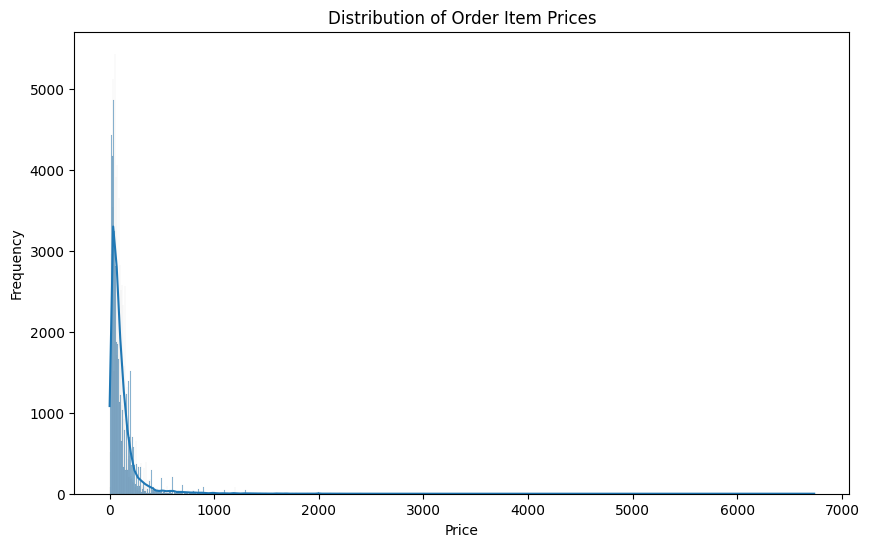

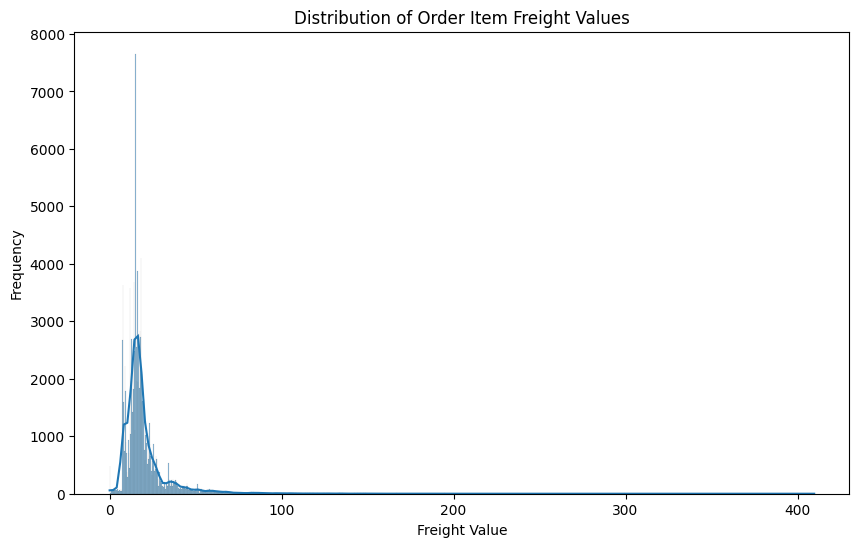

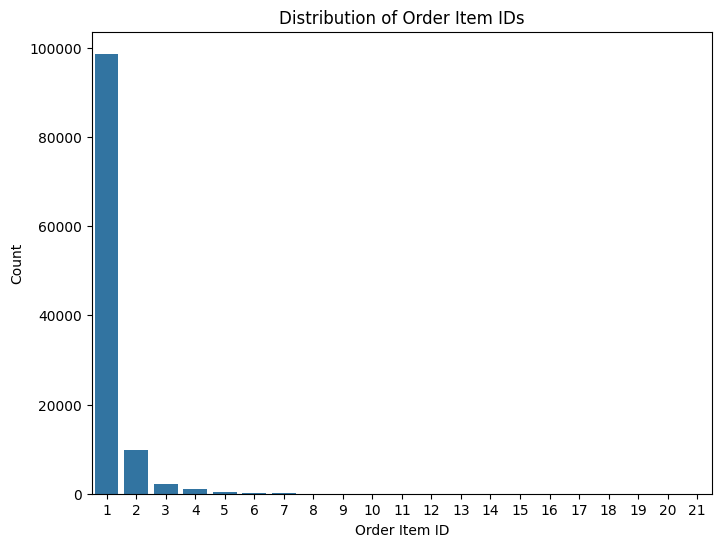

In [158]:
print(df_items.describe(include='all'))

print(df_items['price'].describe())
print(df_items['freight_value'].describe())
print(df_items['order_item_id'].value_counts())

plt.figure(figsize=(10, 6))
sns.histplot(df_items['price'], kde=True)
plt.title('Distribution of Order Item Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_items['freight_value'], kde=True)
plt.title('Distribution of Order Item Freight Values')
plt.xlabel('Freight Value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='order_item_id', data=df_items)
plt.title('Distribution of Order Item IDs')
plt.xlabel('Order Item ID')
plt.ylabel('Count')
plt.show()

## Order Payments Table

                                order_id  payment_sequential payment_type  \
count                             103886       103886.000000       103886   
unique                             99440                 NaN            5   
top     fa65dad1b0e818e3ccc5cb0e39231352                 NaN  credit_card   
freq                                  29                 NaN        76795   
mean                                 NaN            1.092679          NaN   
std                                  NaN            0.706584          NaN   
min                                  NaN            1.000000          NaN   
25%                                  NaN            1.000000          NaN   
50%                                  NaN            1.000000          NaN   
75%                                  NaN            1.000000          NaN   
max                                  NaN           29.000000          NaN   

        payment_installments  payment_value  
count          103886.000000 

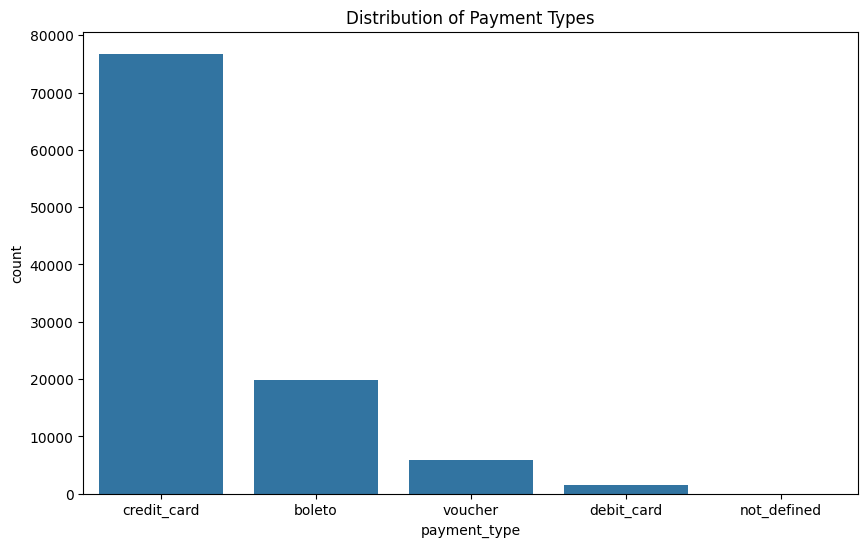

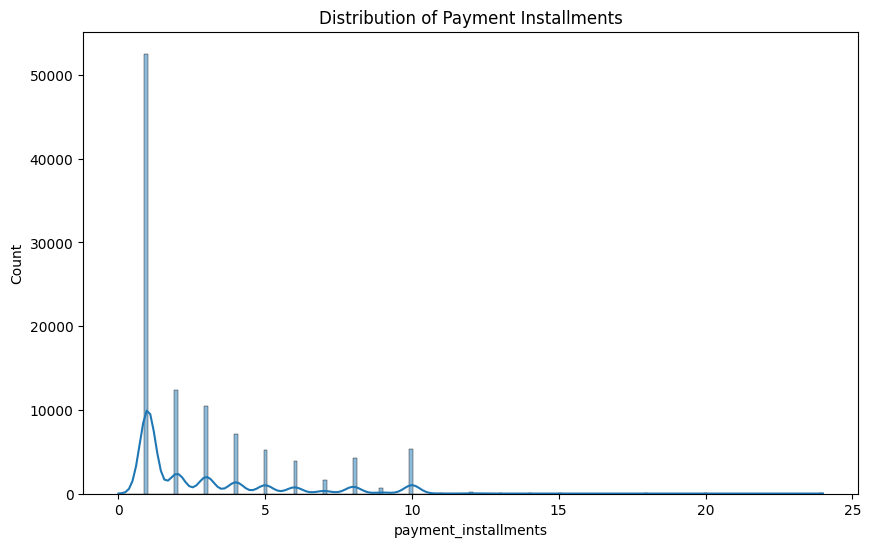

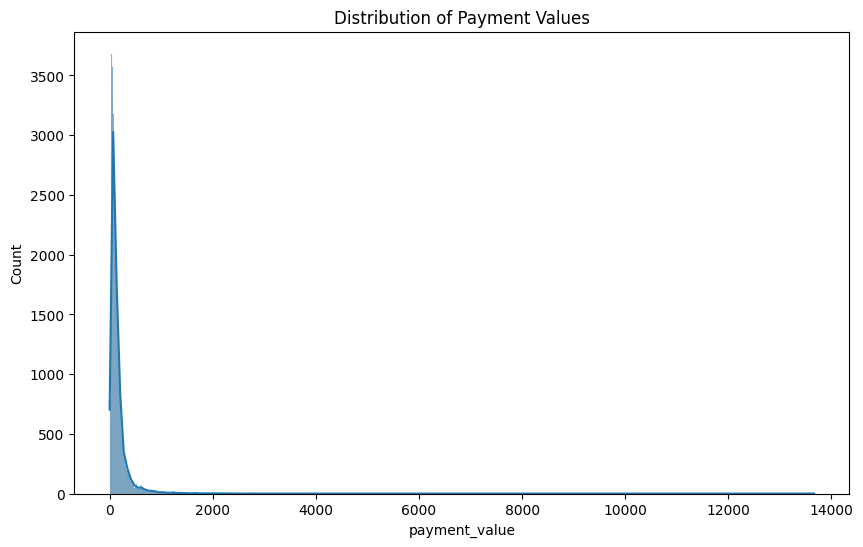

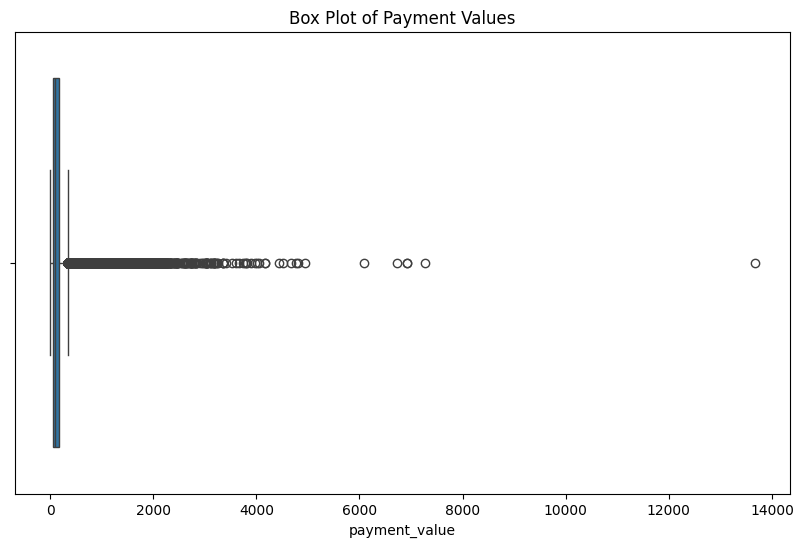

In [159]:
print(df_payments.describe(include='all'))

print(df_payments['payment_type'].value_counts())
print(df_payments['payment_installments'].value_counts())
print(df_payments['payment_value'].describe())

plt.figure(figsize=(10, 6))
sns.countplot(x='payment_type', data=df_payments)
plt.title('Distribution of Payment Types')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_payments['payment_installments'], kde=True)
plt.title('Distribution of Payment Installments')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_payments['payment_value'], kde=True)
plt.title('Distribution of Payment Values')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_payments['payment_value'])
plt.title('Box Plot of Payment Values')
plt.show()


## Order Reviews Table

                               review_id                          order_id  \
count                              99224                             99224   
unique                             98410                             98673   
top     08528f70f579f0c830189efc523d2182  df56136b8031ecd28e200bb18e6ddb2e   
freq                                   3                                 3   
mean                                 NaN                               NaN   
std                                  NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   

        review_score review_comment_title review_comment_messag

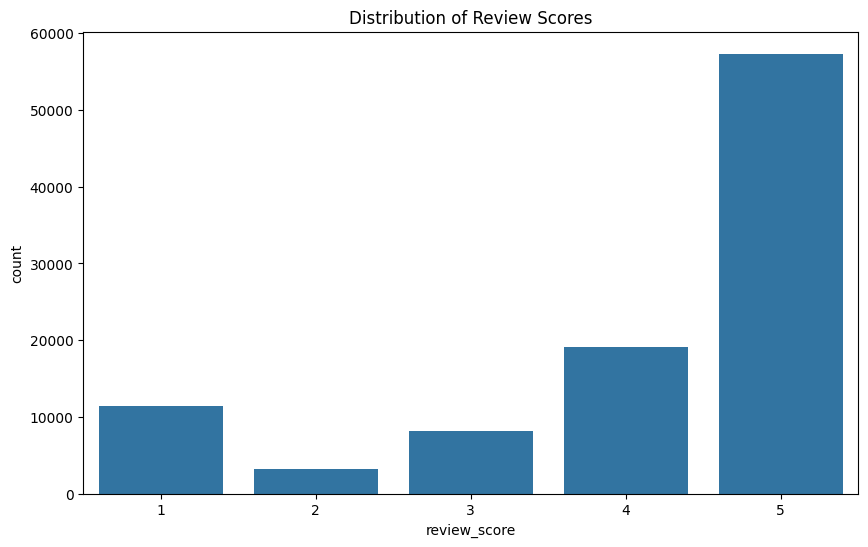

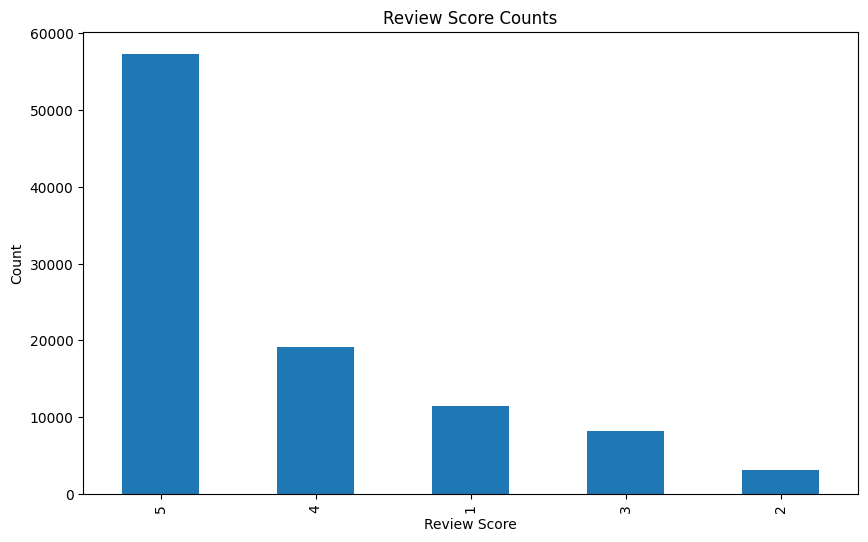

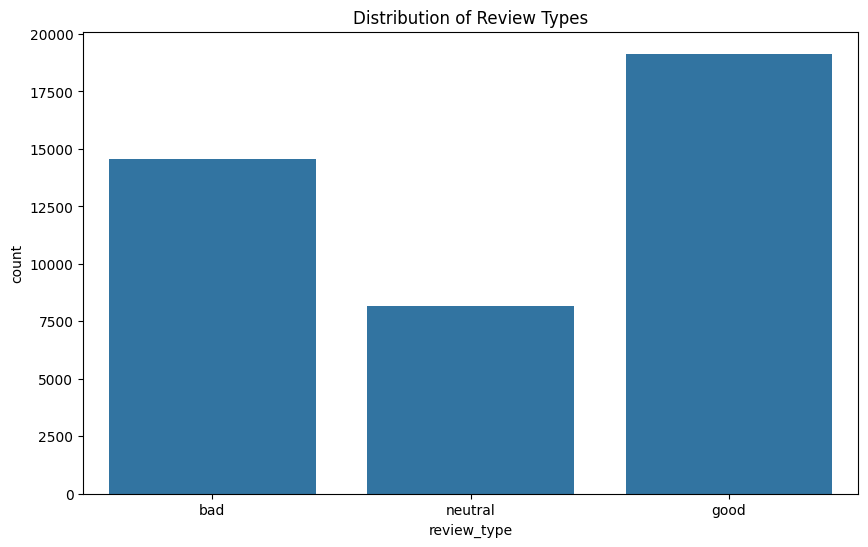

In [160]:
print(df_reviews.describe(include='all'))

print(df_reviews['review_score'].value_counts())
print(df_reviews['review_comment_title'].value_counts())
print(df_reviews['review_comment_message'].value_counts())
print(df_reviews['review_creation_date'].describe())
print(df_reviews['review_answer_timestamp'].describe())


plt.figure(figsize=(10, 6))
sns.countplot(x='review_score', data=df_reviews)
plt.title('Distribution of Review Scores')
plt.show()

plt.figure(figsize=(10, 6))
df_reviews['review_score'].value_counts().plot(kind='bar')
plt.title('Review Score Counts')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x='review_type', data=df_reviews)
plt.title('Distribution of Review Types')
plt.show()


## Orders Table

                                order_id                       customer_id  \
count                              99104                             99104   
unique                             99104                             99104   
top     6ec4642f9993cc34f826cfb9068e5a2f  f00bb12620b7b232233cace1b229db18   
freq                                   1                                 1   

       order_status order_purchase_timestamp    order_approved_at  \
count         99104                    99104                98958   
unique            7                    98541                90454   
top       delivered      2017-11-20 11:46:30  2018-02-27 04:31:10   
freq          96455                        3                    9   

       order_delivered_carrier_date order_delivered_customer_date  \
count                         97637                         96461   
unique                        81006                         95649   
top             2018-05-09 15:48:00           2017-06-19

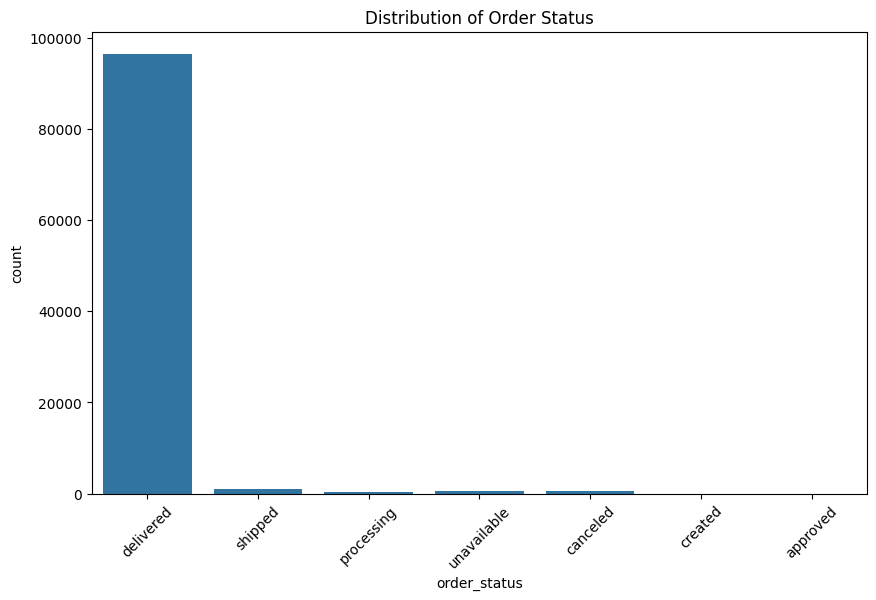

count    96461.000000
mean        12.093582
std          9.551576
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: delivery_time, dtype: float64


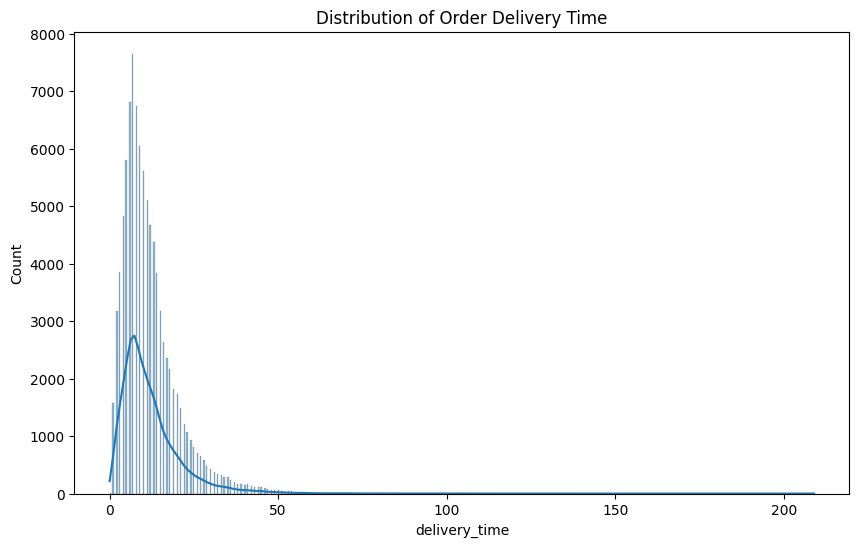

count    96461.000000
mean        10.875577
std         10.183476
min       -189.000000
25%          6.000000
50%         11.000000
75%         16.000000
max        146.000000
Name: delivery_difference, dtype: float64


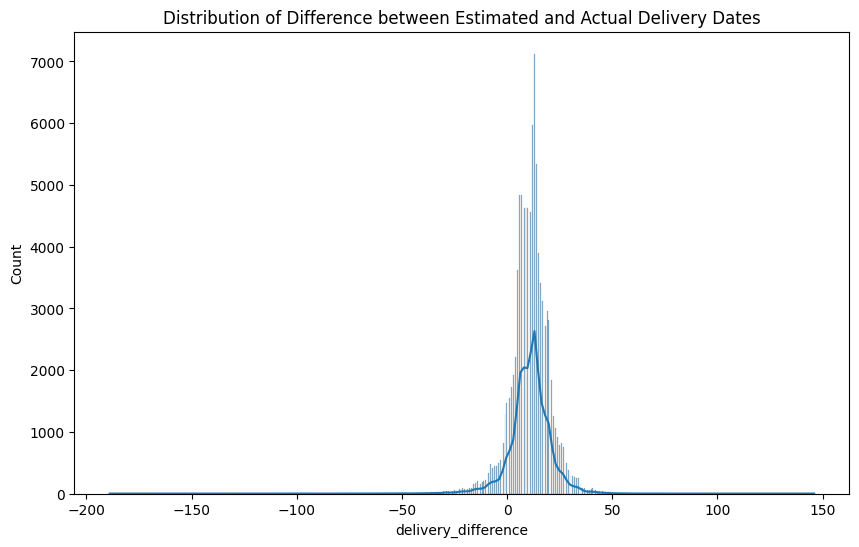

In [161]:
print(df_orders.describe(include='all'))

print(df_orders['order_status'].value_counts())
print(df_orders['order_purchase_timestamp'].describe())
print(df_orders['order_approved_at'].describe())
print(df_orders['order_delivered_carrier_date'].describe())
print(df_orders['order_delivered_customer_date'].describe())
print(df_orders['order_estimated_delivery_date'].describe())

plt.figure(figsize=(10, 6))
sns.countplot(x='order_status', data=df_orders)
plt.title('Distribution of Order Status')
plt.xticks(rotation=45)
plt.show()

for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
    if not pd.api.types.is_datetime64_any_dtype(df_orders[col]):
        df_orders[col] = pd.to_datetime(df_orders[col])


if 'order_purchase_timestamp' in df_orders and 'order_delivered_customer_date' in df_orders:
    df_orders['delivery_time'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']).dt.days
    print(df_orders['delivery_time'].describe())
    plt.figure(figsize=(10, 6))
    sns.histplot(df_orders['delivery_time'].dropna(), kde=True)
    plt.title('Distribution of Order Delivery Time')
    plt.show()

if 'order_estimated_delivery_date' in df_orders and 'order_delivered_customer_date' in df_orders:
    df_orders['delivery_difference'] = (df_orders['order_estimated_delivery_date'] - df_orders['order_delivered_customer_date']).dt.days
    print(df_orders['delivery_difference'].describe())
    plt.figure(figsize=(10,6))
    sns.histplot(df_orders['delivery_difference'].dropna(), kde=True)
    plt.title('Distribution of Difference between Estimated and Actual Delivery Dates')
    plt.show()


## Products Table

                              product_id product_category_name  \
count                              32340                 32340   
unique                             32340                    73   
top     106392145fca363410d287a815be6de4        bed_bath_table   
freq                                   1                  3029   
mean                                 NaN                   NaN   
std                                  NaN                   NaN   
min                                  NaN                   NaN   
25%                                  NaN                   NaN   
50%                                  NaN                   NaN   
75%                                  NaN                   NaN   
max                                  NaN                   NaN   

        product_name_lenght  product_description_lenght  product_photos_qty  \
count          32340.000000                32340.000000        32340.000000   
unique                  NaN                      

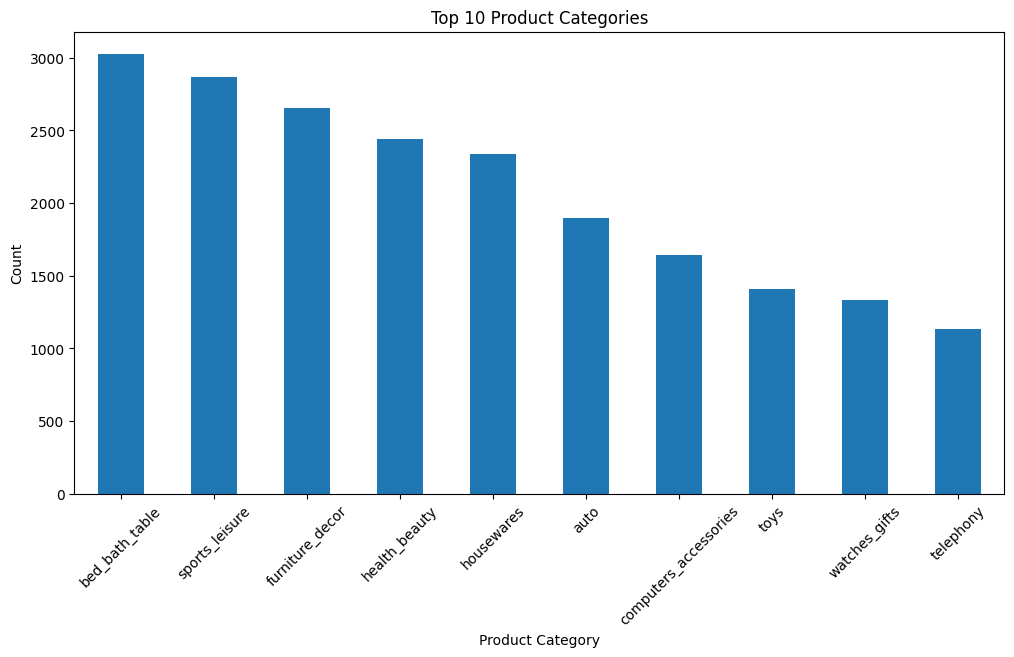

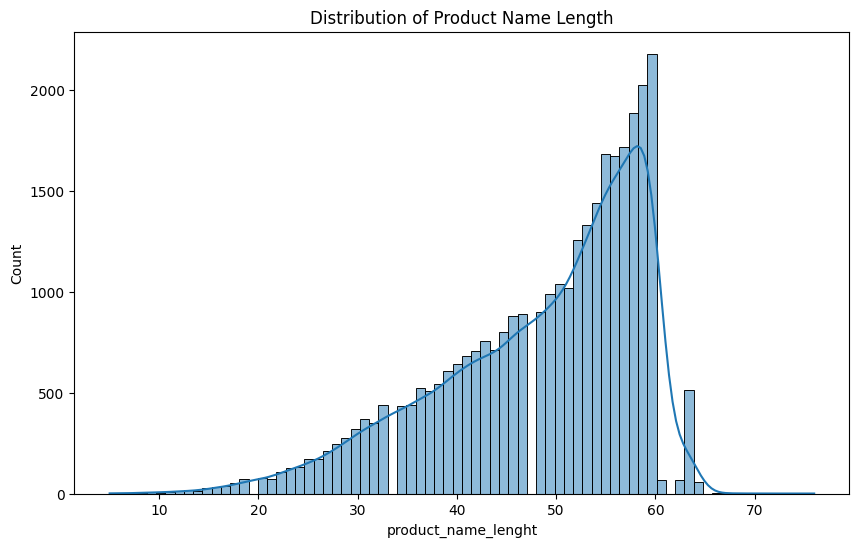

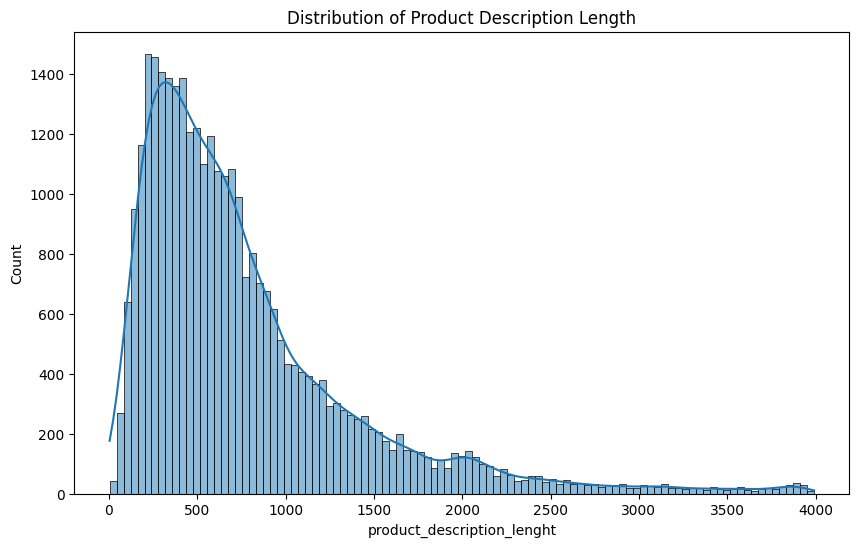

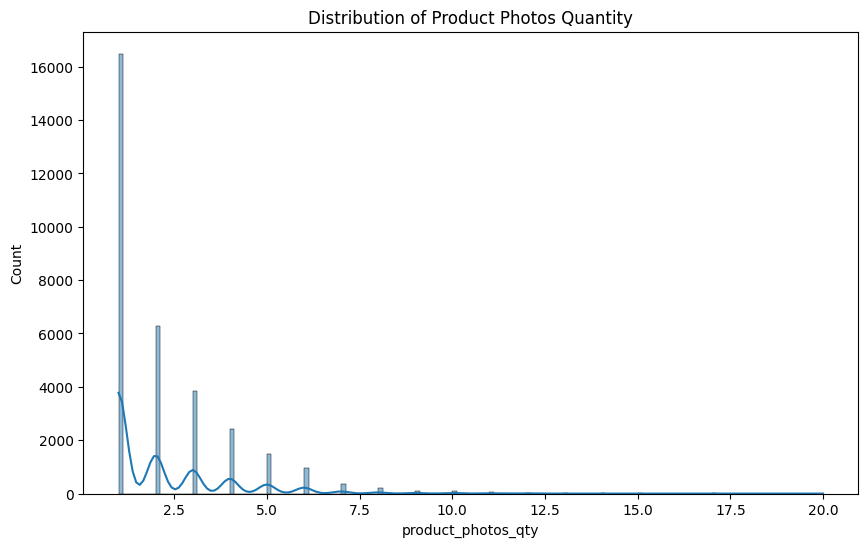

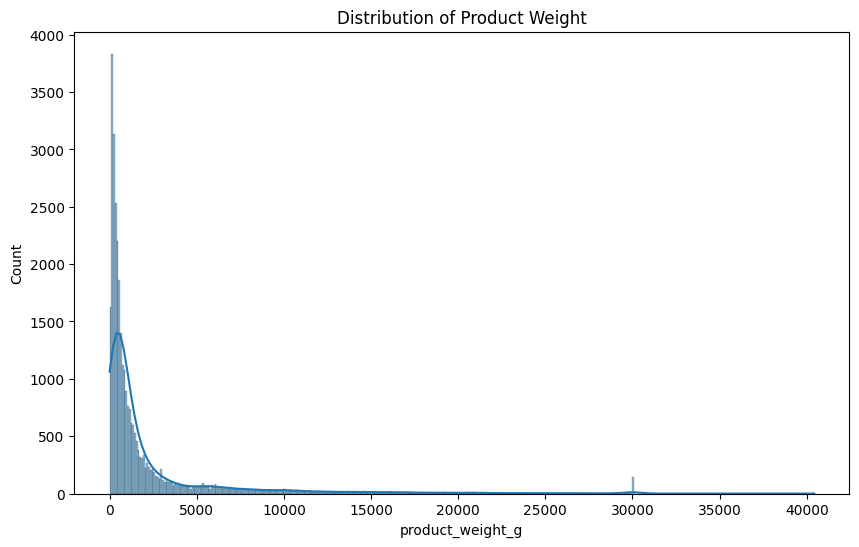

In [162]:
print(df_products.describe(include='all'))

# Explore specific columns
print(df_products['product_category_name'].value_counts())
print(df_products['product_name_lenght'].describe())
print(df_products['product_description_lenght'].describe())
print(df_products['product_photos_qty'].describe())
print(df_products['product_weight_g'].describe())
print(df_products['product_length_cm'].describe())
print(df_products['product_height_cm'].describe())
print(df_products['product_width_cm'].describe())

plt.figure(figsize=(12, 6))
df_products['product_category_name'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_products['product_name_lenght'], kde=True)
plt.title('Distribution of Product Name Length')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_products['product_description_lenght'], kde=True)
plt.title('Distribution of Product Description Length')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_products['product_photos_qty'], kde=True)
plt.title('Distribution of Product Photos Quantity')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_products['product_weight_g'], kde=True)
plt.title('Distribution of Product Weight')
plt.show()

## Sellers Table

                               seller_id  seller_zip_code_prefix seller_city  \
count                               3095             3095.000000        3095   
unique                              3095                     NaN         611   
top     9e25199f6ef7e7c347120ff175652c3b                     NaN   sao paulo   
freq                                   1                     NaN         694   
mean                                 NaN            32291.059451         NaN   
std                                  NaN            32713.453830         NaN   
min                                  NaN             1001.000000         NaN   
25%                                  NaN             7093.500000         NaN   
50%                                  NaN            14940.000000         NaN   
75%                                  NaN            64552.500000         NaN   
max                                  NaN            99730.000000         NaN   

       seller_state  
count          30

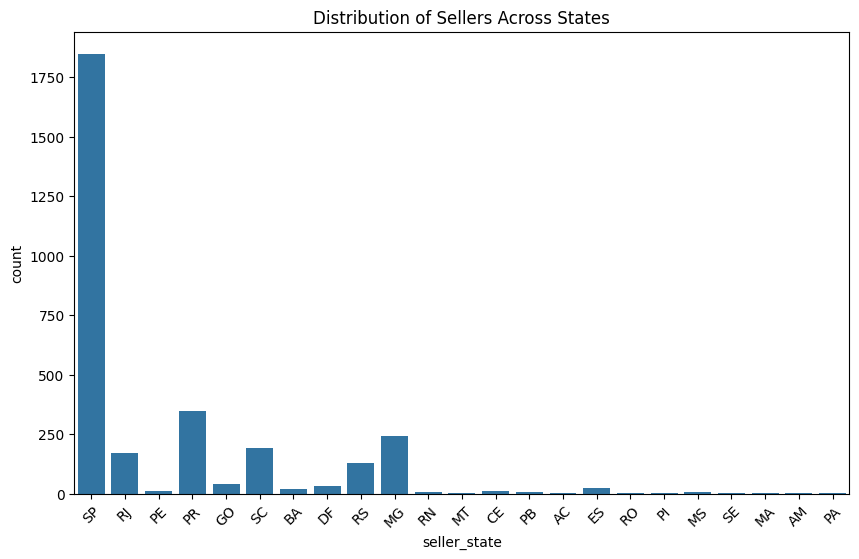

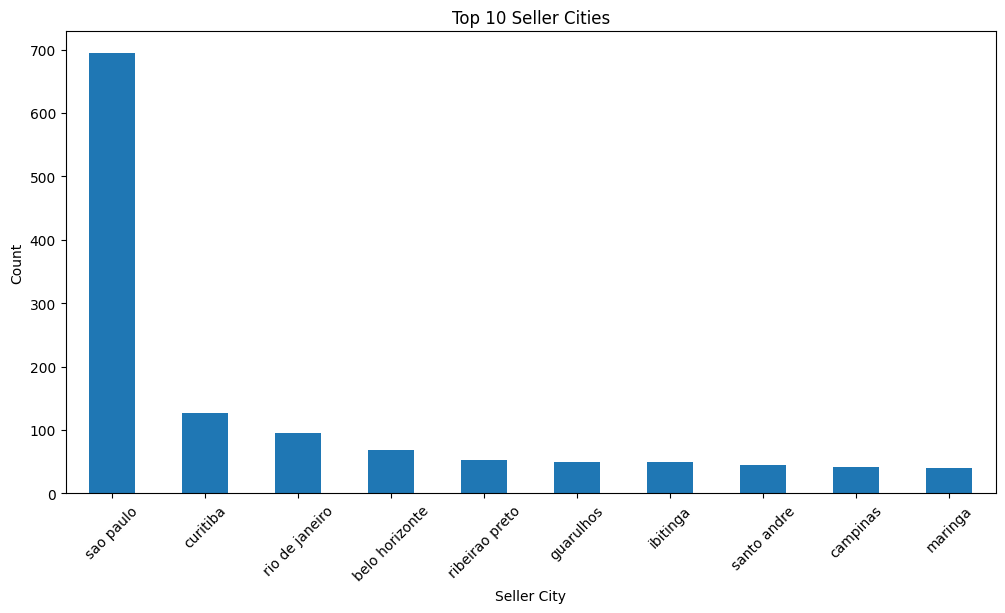

In [163]:
print(df_sellers.describe(include='all'))

# Explore specific columns
print(df_sellers['seller_city'].value_counts())
print(df_sellers['seller_state'].value_counts())

# Visualizations
plt.figure(figsize=(10, 6))
sns.countplot(x='seller_state', data=df_sellers)
plt.title('Distribution of Sellers Across States')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
df_sellers['seller_city'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Seller Cities')
plt.xlabel('Seller City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# Column Correlations

## Geolocations Table

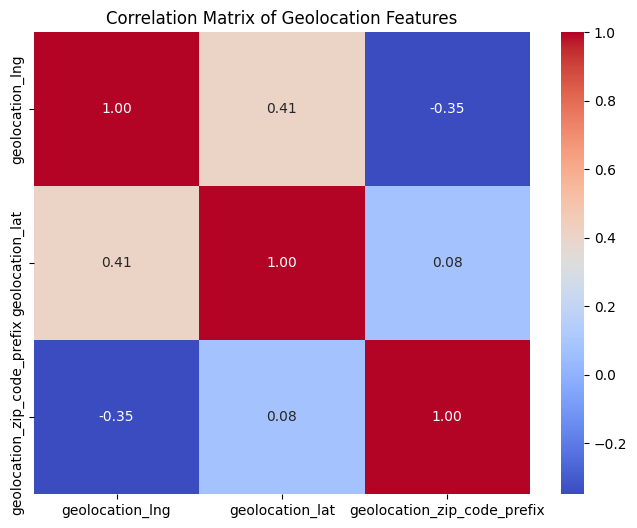

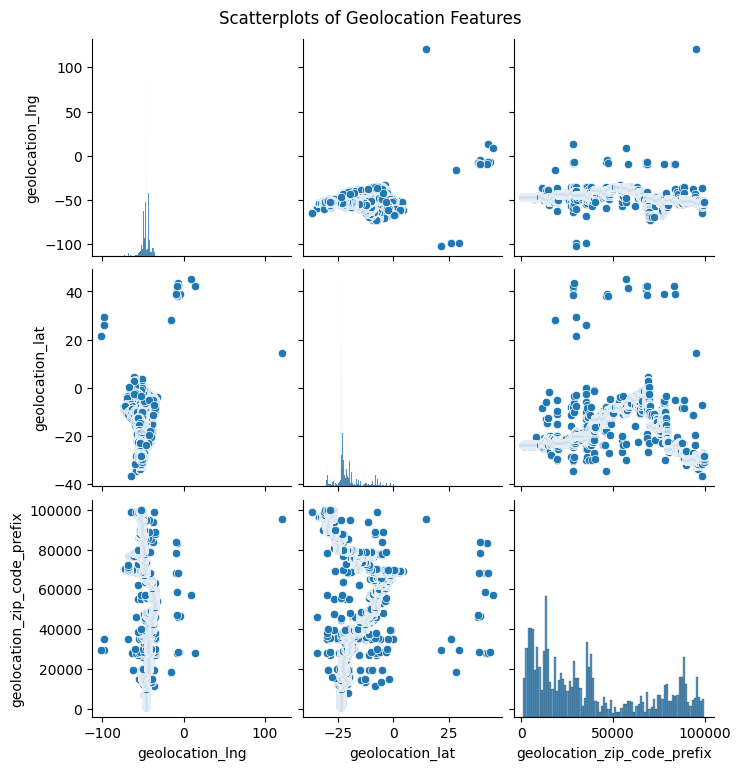

In [164]:
correlation_matrix = df_geolocations[['geolocation_lng', 'geolocation_lat', 'geolocation_zip_code_prefix']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Geolocation Features')
plt.show()


sns.pairplot(df_geolocations[['geolocation_lng', 'geolocation_lat', 'geolocation_zip_code_prefix']])
plt.suptitle('Scatterplots of Geolocation Features', y=1.02)
plt.show()

## Order Items Table

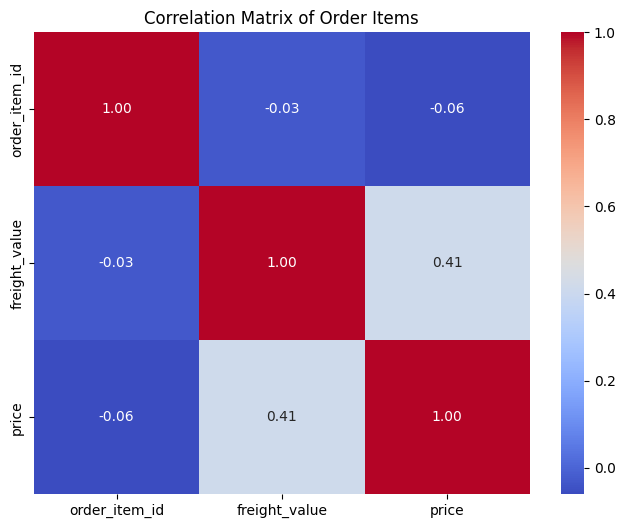

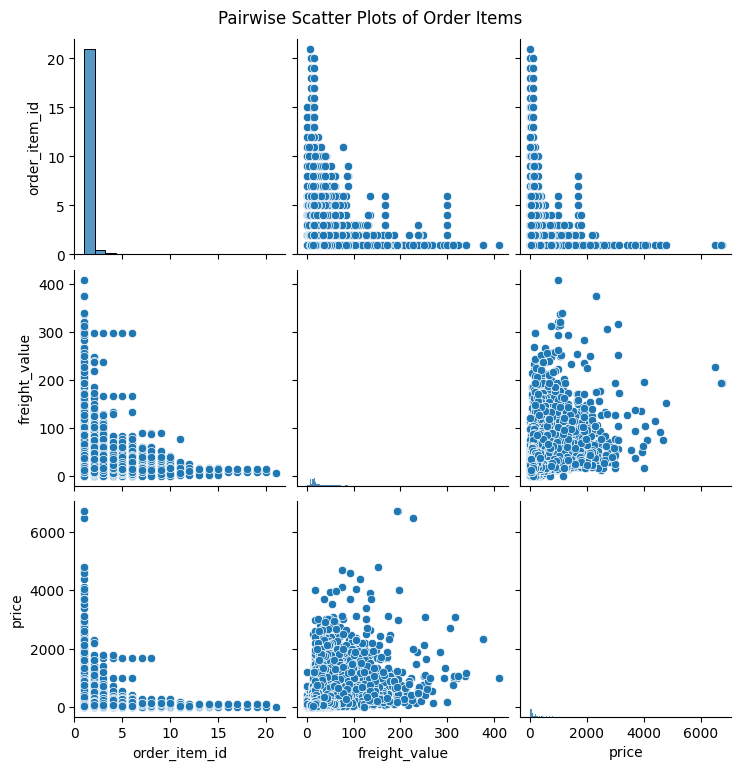

In [165]:
cols_to_analyze = ['order_item_id', 'freight_value', 'price']

# Correlation matrix heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df_items[cols_to_analyze].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Order Items')
plt.show()

# Scatter plots for pairwise relationships
sns.pairplot(df_items[cols_to_analyze])
plt.suptitle('Pairwise Scatter Plots of Order Items', y=1.02)
plt.show()


## Products Table

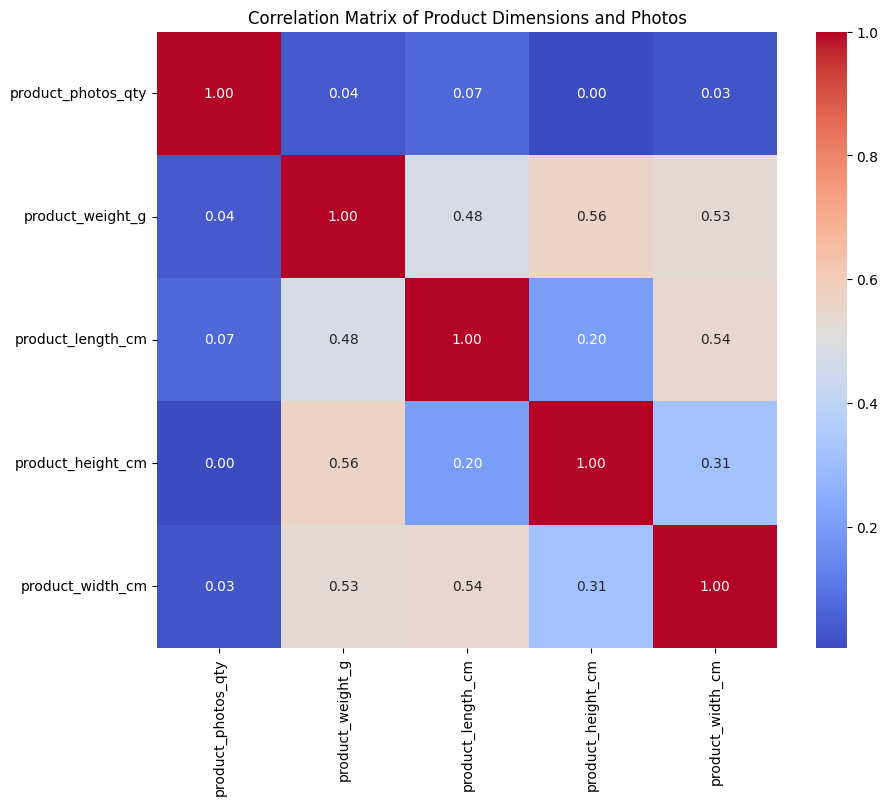

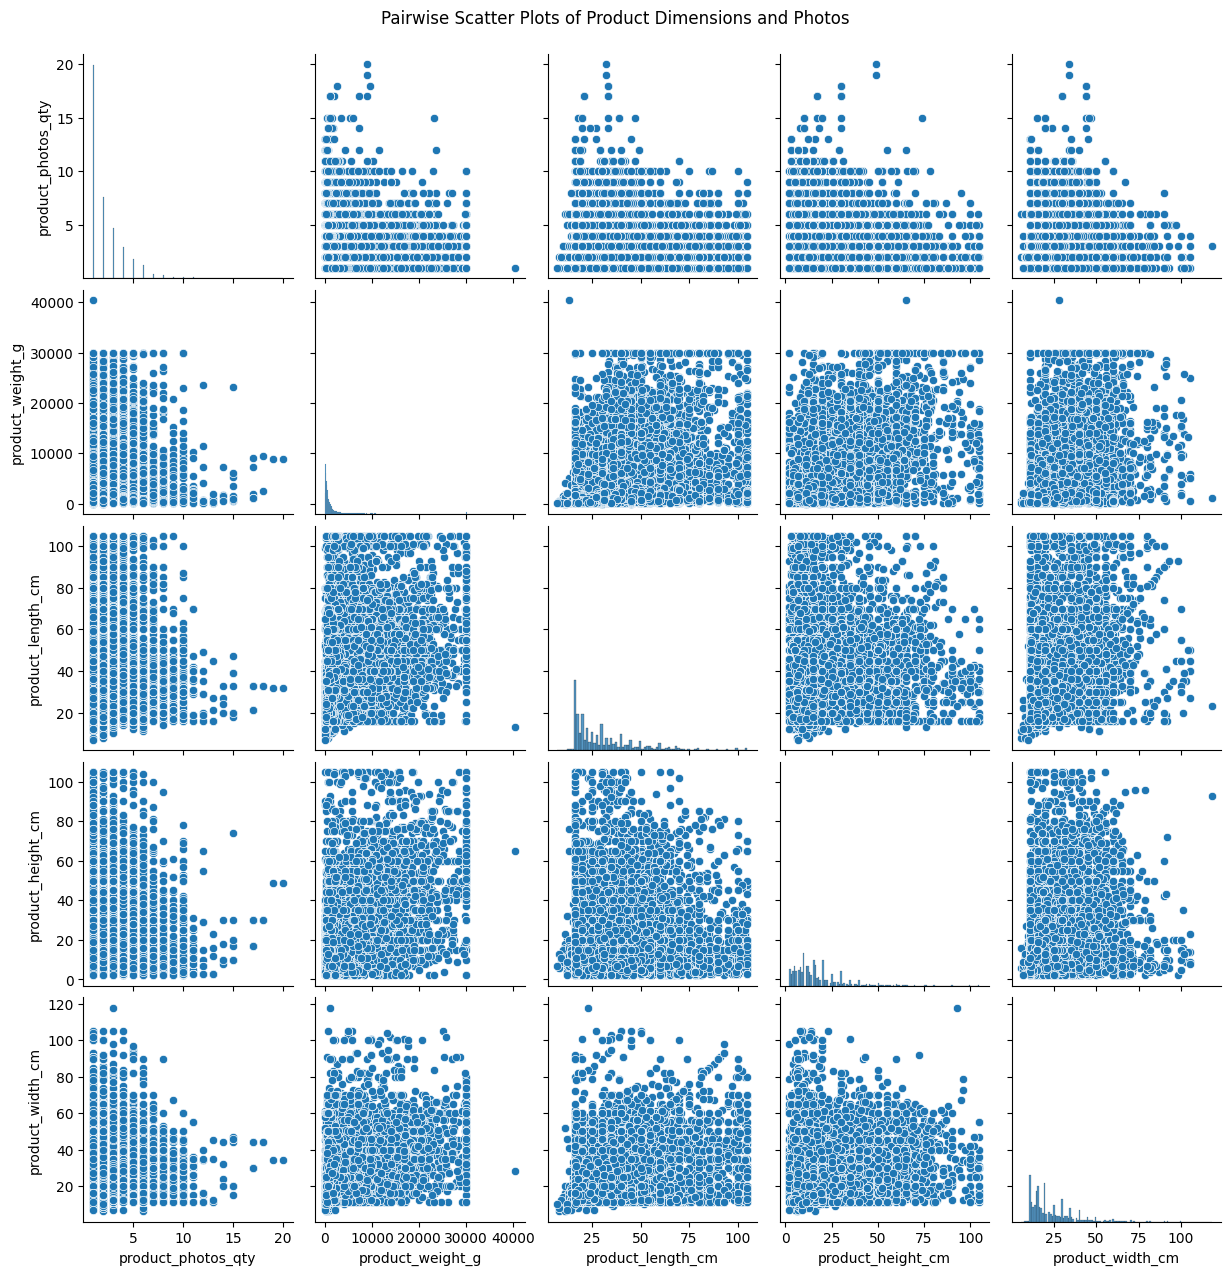

In [166]:
cols_to_analyze = ['product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df_products[cols_to_analyze].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Product Dimensions and Photos')
plt.show()

# Scatter plots for pairwise relationships
sns.pairplot(df_products[cols_to_analyze])
plt.suptitle('Pairwise Scatter Plots of Product Dimensions and Photos', y=1.02)
plt.show()


## Payments Table

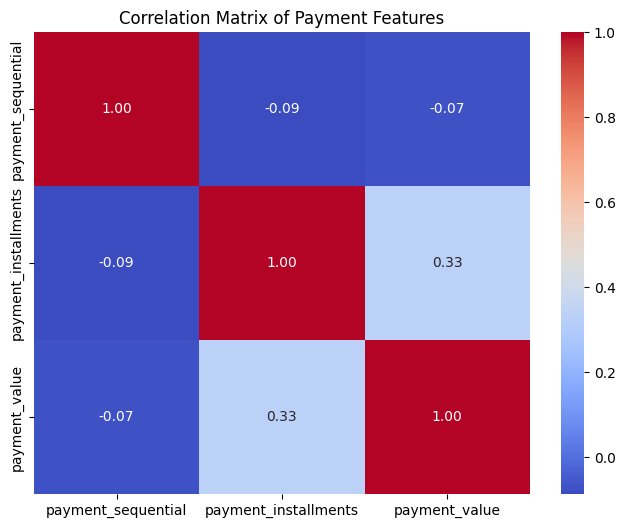

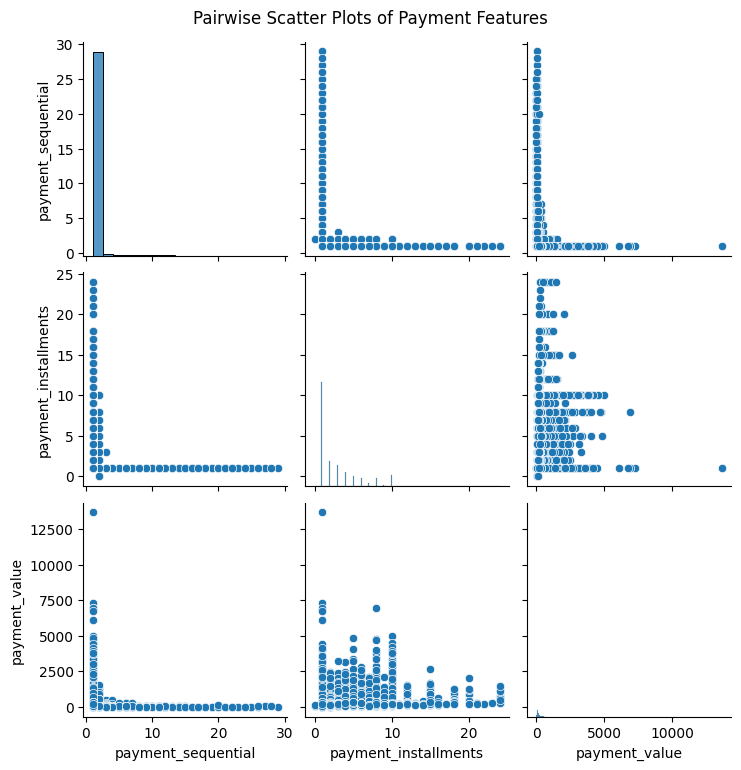

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

cols_to_analyze = ['payment_sequential', 'payment_installments', 'payment_value']

# Correlation matrix heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df_payments[cols_to_analyze].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Payment Features')
plt.show()

# Scatter plots for pairwise relationships
sns.pairplot(df_payments[cols_to_analyze])
plt.suptitle('Pairwise Scatter Plots of Payment Features', y=1.02)
plt.show()




# Merging All Tables

In [168]:
full_df = df_orders.merge(df_reviews, on='order_id')\
                   .merge(df_payments, on='order_id')\
                   .merge(df_customers, on='customer_id')\
                   .merge(df_items, on='order_id')\
                   .merge(df_products, on='product_id')\
                   .merge(df_sellers, on='seller_id')

# Drop duplicates
full_df = full_df.drop_duplicates()

print(full_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106556 entries, 0 to 106555
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       106556 non-null  object        
 1   customer_id                    106556 non-null  object        
 2   order_status                   106556 non-null  object        
 3   order_purchase_timestamp       106556 non-null  datetime64[ns]
 4   order_approved_at              106556 non-null  datetime64[ns]
 5   order_delivered_carrier_date   105791 non-null  datetime64[ns]
 6   order_delivered_customer_date  104683 non-null  datetime64[ns]
 7   order_estimated_delivery_date  106556 non-null  datetime64[ns]
 8   delivery_time                  104683 non-null  float64       
 9   delivery_difference            104683 non-null  float64       
 10  review_id                      106556 non-null  object        
 11  

# Exploratory Data Analysis

## Sales Trend Over Time

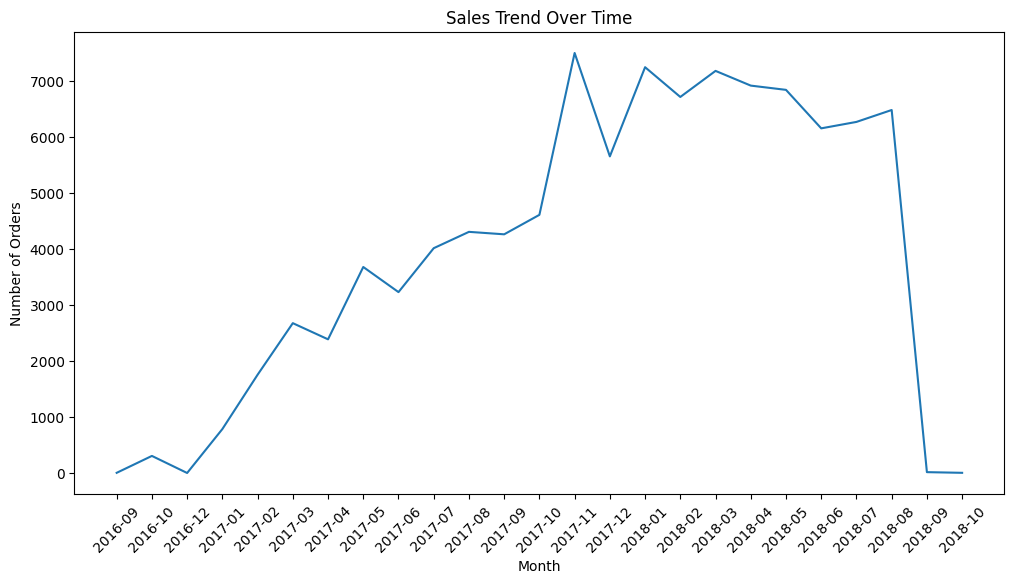

In [169]:
plt.figure(figsize=(12, 6))
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
sales_by_month = df_orders.groupby(df_orders['order_purchase_timestamp'].dt.to_period('M'))['order_id'].count()
sns.lineplot(x=sales_by_month.index.astype(str), y=sales_by_month.values)
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.title("Sales Trend Over Time")
plt.xticks(rotation=45)
plt.show()

## Customer and Seller Distribution

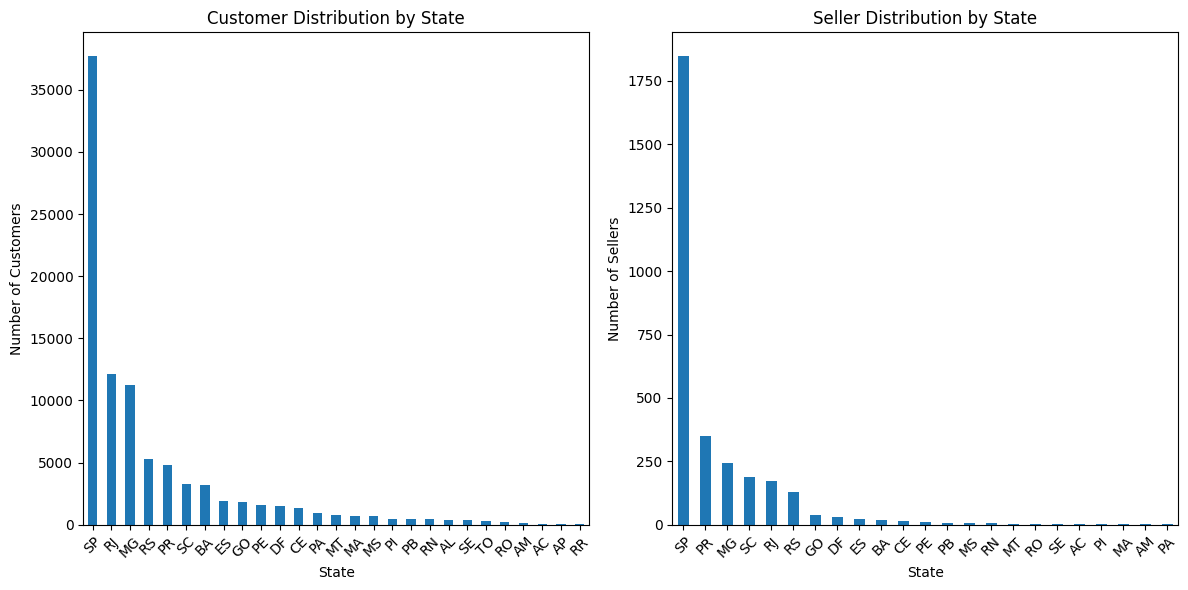

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df_customers['customer_state'].value_counts().plot(kind='bar')
plt.title('Customer Distribution by State')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df_sellers['seller_state'].value_counts().plot(kind='bar')
plt.title('Seller Distribution by State')
plt.xlabel('State')
plt.ylabel('Number of Sellers')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Average Delivery Time by Customer State

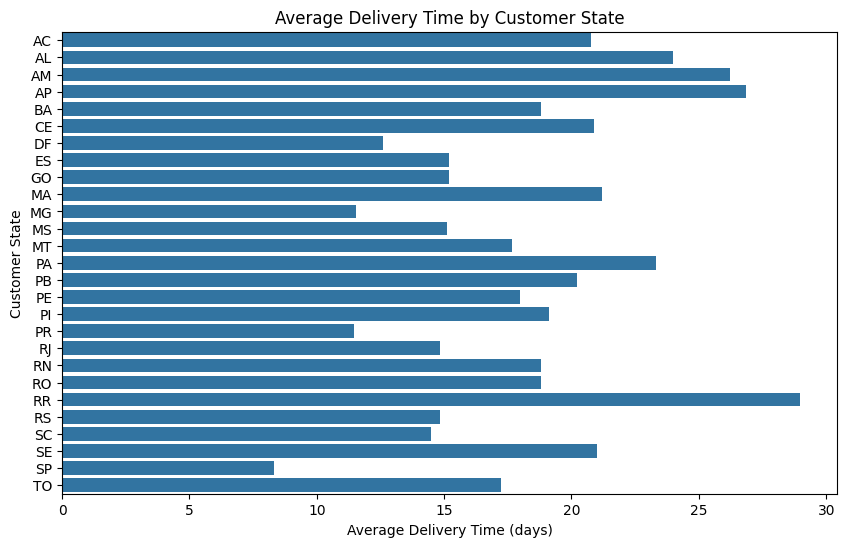

In [171]:
import matplotlib.pyplot as plt


merged_df = pd.merge(df_orders, df_customers, on='customer_id', how='left')

avg_delivery_time_by_state = merged_df.groupby('customer_state')['delivery_time'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='delivery_time', y='customer_state', data=avg_delivery_time_by_state)
plt.xlabel("Average Delivery Time (days)")
plt.ylabel("Customer State")
plt.title("Average Delivery Time by Customer State")
plt.xticks(rotation=0)
plt.show()


## Average Order Value Over Time



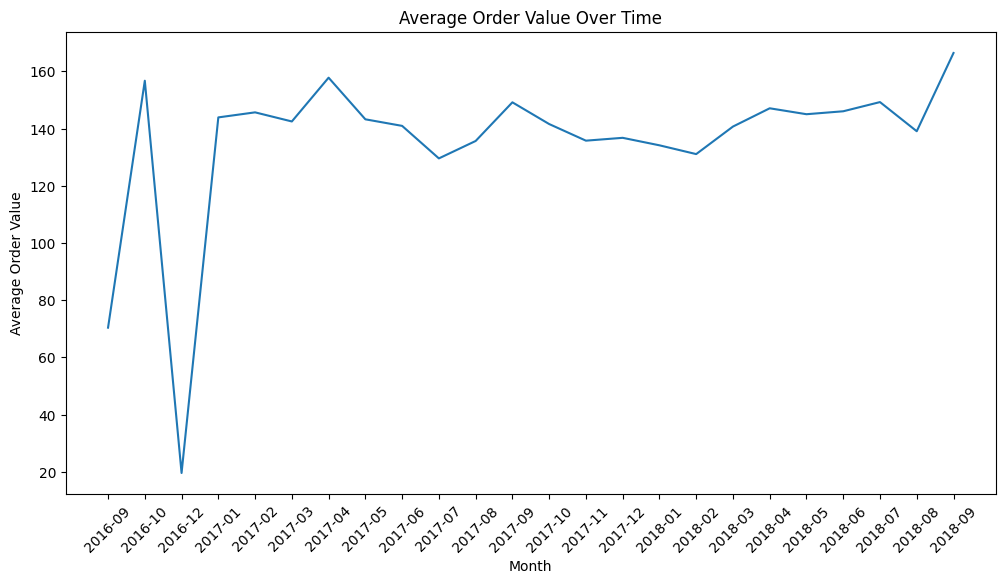

In [172]:
full_df['total_order_value'] = full_df['price'] + full_df['freight_value']

# Group by order date and calculate the average order value
full_df['order_purchase_timestamp'] = pd.to_datetime(full_df['order_purchase_timestamp'])
average_order_value_over_time = full_df.groupby(full_df['order_purchase_timestamp'].dt.to_period('M'))['total_order_value'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=average_order_value_over_time.index.astype(str), y=average_order_value_over_time.values)
plt.xlabel("Month")
plt.ylabel("Average Order Value")
plt.title("Average Order Value Over Time")
plt.xticks(rotation=45)
plt.show()


## Average Delivery Time by Category

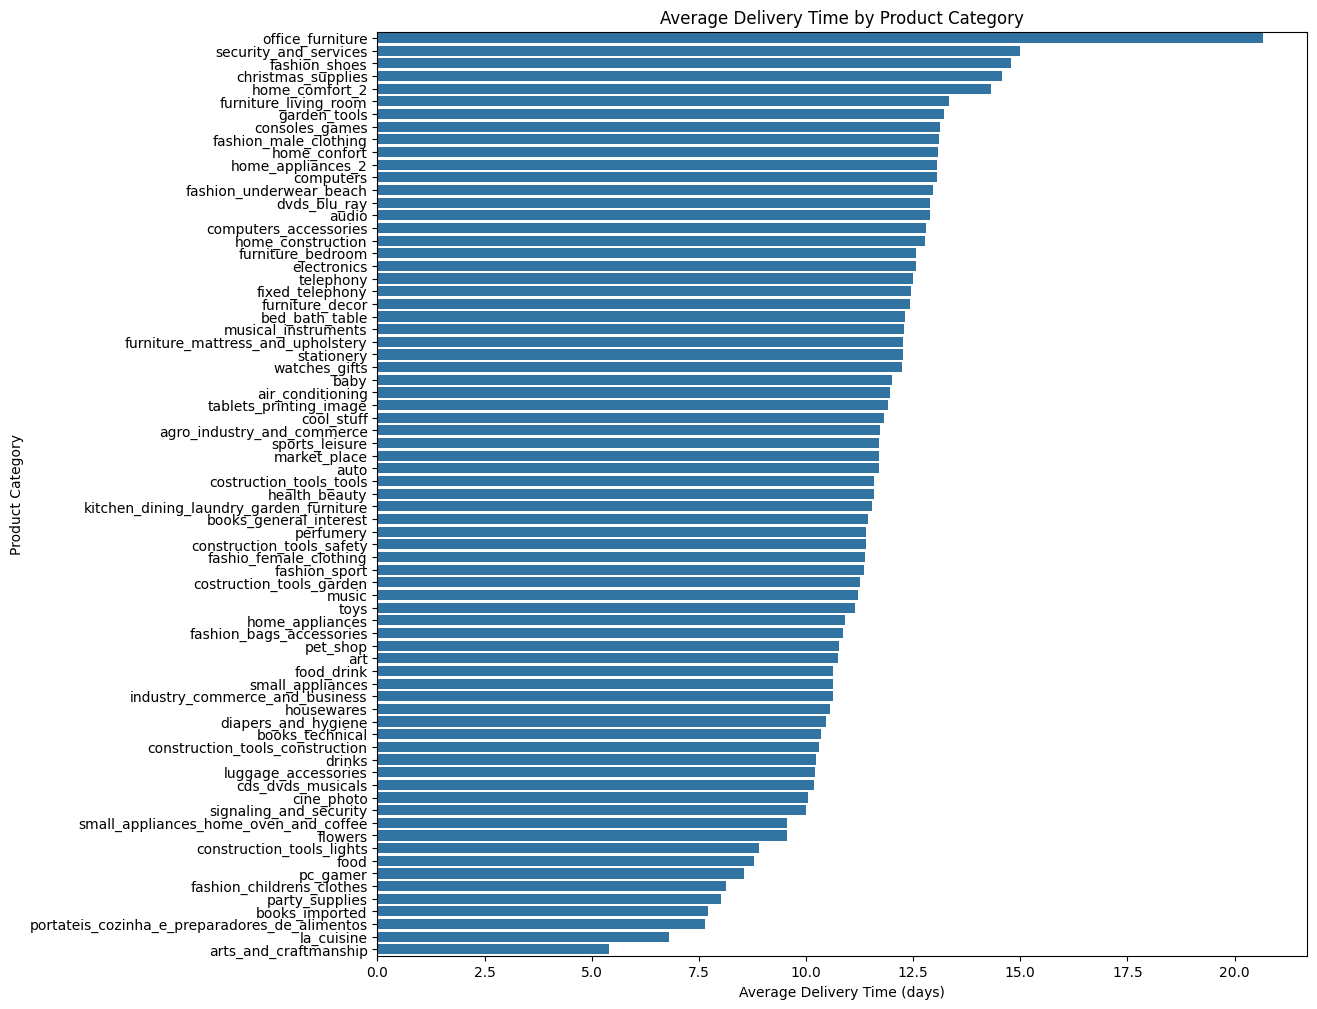

In [173]:
full_df['order_delivered_customer_date'] = pd.to_datetime(full_df['order_delivered_customer_date'])
full_df['order_purchase_timestamp'] = pd.to_datetime(full_df['order_purchase_timestamp'])

# Calculate delivery time
full_df['delivery_time'] = (full_df['order_delivered_customer_date'] - full_df['order_purchase_timestamp']).dt.days

# Group by product category and calculate the average delivery time
average_delivery_time_by_category = full_df.groupby('product_category_name')['delivery_time'].mean().sort_values(ascending=False).reset_index()


plt.figure(figsize=(12, 12))
sns.barplot(x='delivery_time', y='product_category_name', data=average_delivery_time_by_category)
plt.xlabel("Average Delivery Time (days)")
plt.ylabel("Product Category")
plt.title("Average Delivery Time by Product Category")
plt.xticks(rotation=0)
plt.show()


## Geolocation Map

In [174]:
import folium
from folium.plugins import HeatMap

heat_data = df_geolocations[["geolocation_lat", "geolocation_lng"]].values.tolist()

m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)


HeatMap(heat_data, radius=10).add_to(m)

m.save("customer_geo_distribution_heatmap.html")
m

ModuleNotFoundError: No module named 'folium'

## Average Processing Time by Month

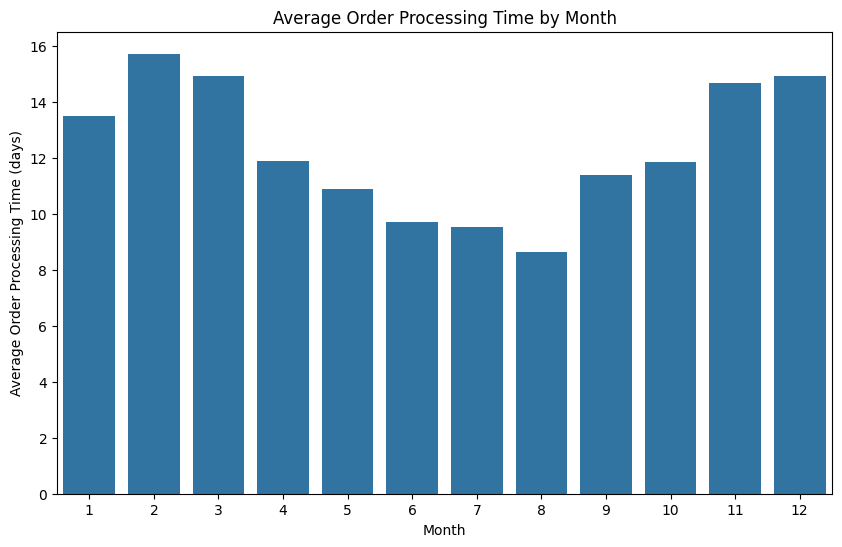

In [ ]:
for col in ['order_purchase_timestamp', 'order_delivered_customer_date']:
    if not pd.api.types.is_datetime64_any_dtype(df_orders[col]):
        df_orders[col] = pd.to_datetime(df_orders[col])

# Calculate order processing time
df_orders['processing_time'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']).dt.days

# Extract the month
df_orders['month'] = df_orders['order_purchase_timestamp'].dt.month

average_processing_time_by_month = df_orders.groupby('month')['processing_time'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=average_processing_time_by_month.index, y=average_processing_time_by_month.values)
plt.xlabel("Month")
plt.ylabel("Average Order Processing Time (days)")
plt.title("Average Order Processing Time by Month")
plt.show()


## Number of Orders per Day of the Week

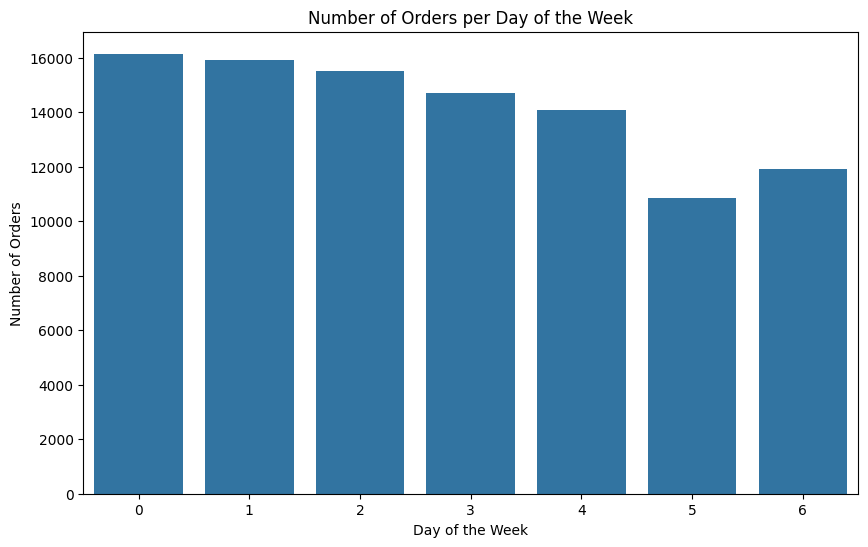

In [ ]:
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])

df_orders['day_of_week'] = df_orders['order_purchase_timestamp'].dt.dayofweek

orders_by_day = df_orders.groupby('day_of_week')['order_id'].count()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=orders_by_day.index, y=orders_by_day.values)
plt.xlabel("Day of the Week")
plt.ylabel("Number of Orders")
plt.title("Number of Orders per Day of the Week")
plt.show()


## Word Cloud of Review Comments

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


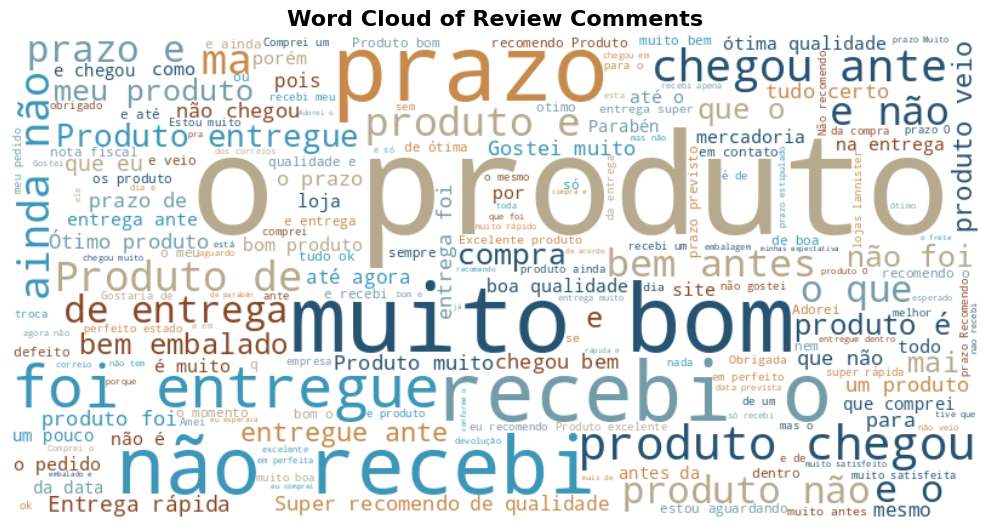

In [ ]:
colors = ["#26536f", "#3b96b7", "#749ca8", "#b6a98d", "#c78a4d", "#854927"]
sns.set_palette(colors)

# Sentiment Analysis
from LeIA import SentimentIntensityAnalyzer

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Define a color function
def color_func(word, font_size, position, orientation, random_state=42, **kwargs):
    return random.choice(colors)

# Example: Word cloud from review comments
plt.figure(figsize=(10, 10))

wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(' '.join(df_reviews['review_comment_message'].dropna()))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Review Comments', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

## Distribution of Total Amount spent by a Customer

<ipython-input-67-96d0bd787a25>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(full_df['total_order_value'],palette="flare", kde=True)


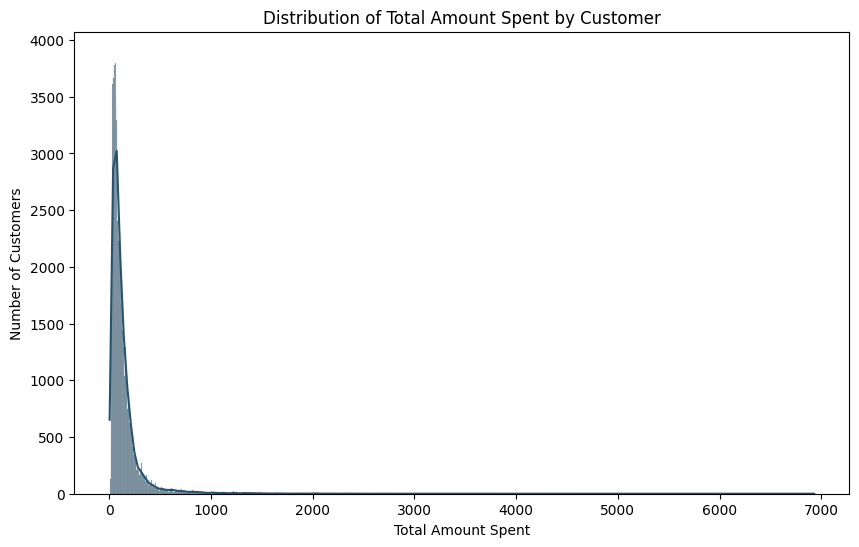

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(full_df['total_order_value'], kde=True)
plt.title('Distribution of Total Amount Spent by Customer')
plt.xlabel('Total Amount Spent')
plt.ylabel('Number of Customers')
plt.show()


## Calculate Total Sales per Product Category

<ipython-input-66-419f69ab68f5>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="flare")


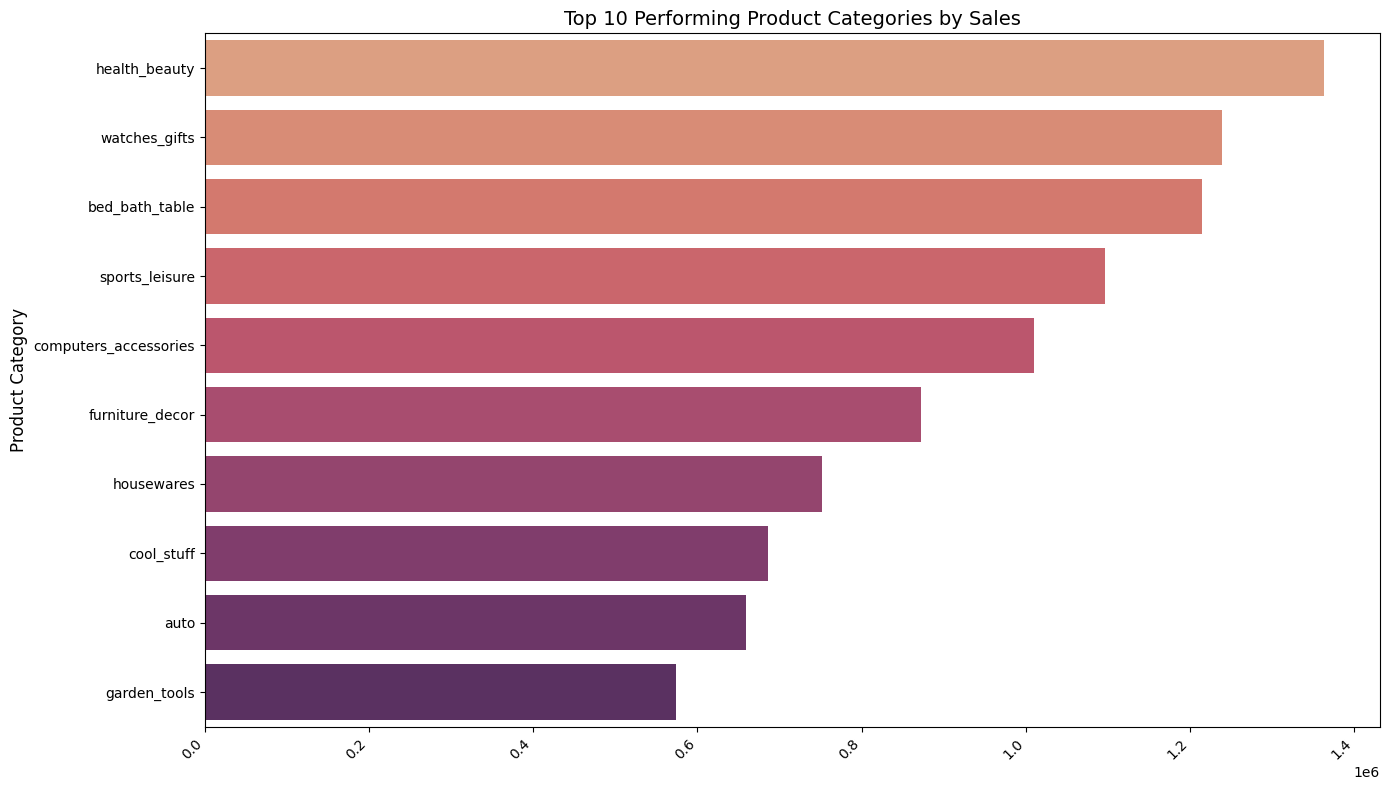

In [ ]:
# Calculate total sales per product category
category_sales = full_df.groupby('product_category_name')['total_order_value'].sum().sort_values(ascending=False)

top_n = 10
top_categories = category_sales.head(top_n)

plt.figure(figsize=(14, 8))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="flare")
plt.ylabel("Product Category", fontsize=12)
plt.title(f"Top {top_n} Performing Product Categories by Sales", fontsize=14)
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


## Review Score VS Delivery Time

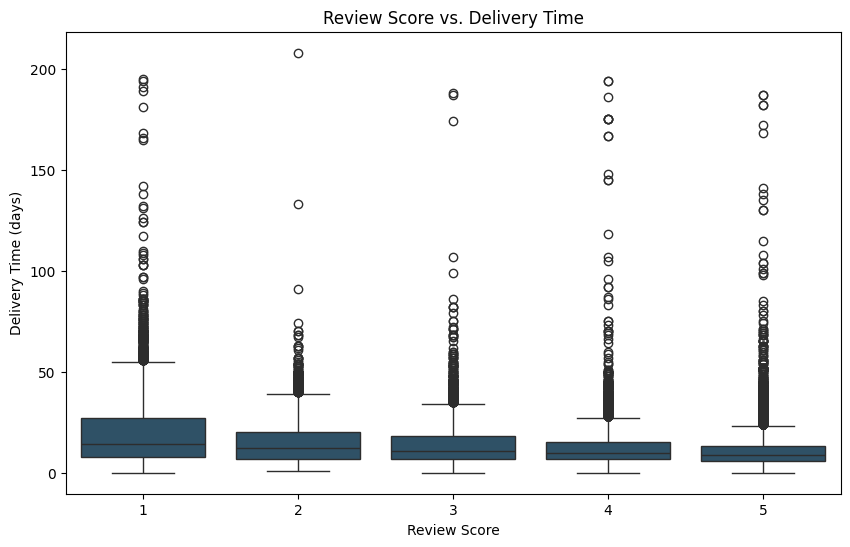

In [ ]:
sns.boxplot(x='review_score', y='delivery_time', data=full_df)
plt.xlabel('Review Score')
plt.ylabel('Delivery Time (days)')
plt.title('Review Score vs. Delivery Time')
plt.show()


In [75]:
# Save the full_df DataFrame to a CSV file inside the data folder
full_df.to_csv('./data/full_df.csv', index=False)